## MSCRED (Multi Scale Convolutional Recurrent Encoder Decoder)

Ce script vise  a tester toutes les briques qui compose le pipeline MSCRED sur des données fictives pour ensuite créer le module qui sera utile dans notre projet de détection d'anomalie dans les flux de diagnostiques magnétique de tokamak !

### 1. Création des jeux de données et visualisation

1. Créer des signaux multivariés aléatoires et les visualiser. (ils constitueront le jeu d'entrainement)
2. Reprendre ce jeu synthétique et pour un sous-groupe, y ajouter des valeurs abérantes pour qu'ils soient les anomalies à détecter. Labeliser le tout (constituera le jeu de test).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_multivariate_ts_1(n_variables, n_timesteps, noise_level=0.1, seed=None):
    """
    Generates realistic multivariate time series with temporal continuity and noise.
    
    Args:
        n_variables (int): Number of time series (variables)
        n_timesteps (int): Length of time series
        noise_level (float): Gaussian noise level (standard deviation)
        seed (int): Seed for reproducibility
        
    Returns:
        np.array: Matrix of time series of shape (n_variables, n_timesteps)
    """

    if seed is not None:
        np.random.seed(seed)
    
    # Matrice initialization
    data = np.zeros((n_variables, n_timesteps))
    
    # Unique parameters for each variable
    means = np.random.uniform(-10, 10, n_variables)             # Means
    volatilities = np.random.uniform(0.1, 1.0, n_variables)     # Volatilities
    trends = np.random.uniform(-0.05, 0.05, n_variables)        # Trends
    frequencies = np.random.uniform(0.01, 0.2, n_variables)     # frequencies
    
    for i in range(n_variables):
        # Random generation of the base time series (AR(1) process)
        base = np.zeros(n_timesteps)
        base[0] = np.random.normal(means[i], volatilities[i])
        
        # Adding temporal continuity
        for t in range(1, n_timesteps):
            # Autoregressive component with trend and seasonality
            drift = trends[i] * t
            season = 0.5 * np.sin(2 * np.pi * frequencies[i] * t)
            innovation = np.random.normal(0, volatilities[i])
            
            base[t] = (0.8 * base[t-1] + 0.2 * base[0] + 
                       drift + season + innovation)
        
        data[i] = base
    
    # Adding Gaussian noise
    noise = np.random.normal(0, noise_level, (n_variables, n_timesteps))
    return data + noise

In [3]:
def generate_multivariate_ts_2(n_variables: int, n_timesteps: int, noise_level: float = 0.1, seed:bool = None) -> np.ndarray:
    """
    Improved version with amplitude control and large-scale sinusoids.
    
    Args:
        n_variables (int): Number of time series
        n_timesteps (int): Length of series
        noise_level (float): Noise level (standard deviation)
        seed (int): Seed for reproducibility
        
    Returns:
        np.array: Matrix of shape (n_variables, n_timesteps)
    """
    if seed is not None:
        np.random.seed(seed)
    
    data = np.zeros((n_variables, n_timesteps), dtype=np.float32)
    time = np.arange(n_timesteps, dtype=np.float32)
    
    #Unique parameters for each variable
    base_amps = np.random.uniform(5, 20, n_variables)  # Amplitude de base
    slow_freqs = np.random.uniform(0.001, 0.01, n_variables)  # Fréquences lentes
    fast_freqs = np.random.uniform(0.05, 0.2, n_variables)  # Fréquences rapides
    phases = np.random.uniform(0, 2*np.pi, n_variables)  # Déphasages
    
    for i in range(n_variables):
        # Primary component (slow sinusoid)
        slow_wave = base_amps[i] * np.sin(2 * np.pi * slow_freqs[i] * time + phases[i])
        
        # Secondary component (fast sinusoid)
        fast_wave = 0.5 * base_amps[i] * np.sin(2 * np.pi * fast_freqs[i] * time)
        
        # Autoregressive noise component
        # AR(1) process with a random walk component
        ar_noise = np.zeros(n_timesteps)
        ar_noise[0] = np.random.normal(0, 1)
        for t in range(1, n_timesteps):
            ar_noise[t] = 0.7 * ar_noise[t-1] + np.random.normal(0, 0.5)
        
        # Combining components
        data[i] = slow_wave + fast_wave + ar_noise
    
    # Mesurement noise
    noise = np.random.normal(0, noise_level, (n_variables, n_timesteps))
    data = data + noise
    return (data - np.mean(data, axis=1, keepdims=True)) / np.std(data, axis=1, keepdims=True)

In [4]:
def generate_multivariate_ts_3(
    n_variables: int,
    n_timesteps: int,
    noise_level: float = 0.3,
    min_delay: int = 50,
    max_delay: int = 100,
    min_freq: int = 40,
    max_freq: int = 50,
    seed: int = None
) -> np.ndarray:
    """
    Generates synthetic multivariate time series with trigonometric patterns and noise.
    Implementation like in the MSCRED paper.

    Args:
        n_variables: Number of time series (variables/sensors)
        n_timesteps: Length of time series
        noise_level: Gaussian noise level
        min_delay: Minimum time delay (t0)
        max_delay: Maximum time delay (t0)
        min_freq: Minimum angular frequency (ω)
        max_freq: Maximum angular frequency (ω)
        seed: Seed for reproducibility

    Returns:
        A numpy array of shape (n_variables, n_timesteps)
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Generate random parameters for each variable
    s_rand = np.random.randint(0, 2, size=n_variables)  # 0=sin, 1=cos
    t0 = np.random.randint(min_delay, max_delay + 1, size=n_variables)
    omega = np.random.randint(min_freq, max_freq + 1, size=n_variables)
    
    # Initialize the time series data matrix
    ts_data = np.zeros((n_variables, n_timesteps))
    time_index = np.arange(n_timesteps)
    
    for i in range(n_variables):
        base = (time_index - t0[i]) / omega[i]
        if s_rand[i] == 0:
            trig_component = np.sin(base)
        else:
            trig_component = np.cos(base)
        
        # Add gaussian noise
        noise = noise_level * np.random.randn(n_timesteps)
        ts_data[i] = trig_component + noise
    
    return ts_data

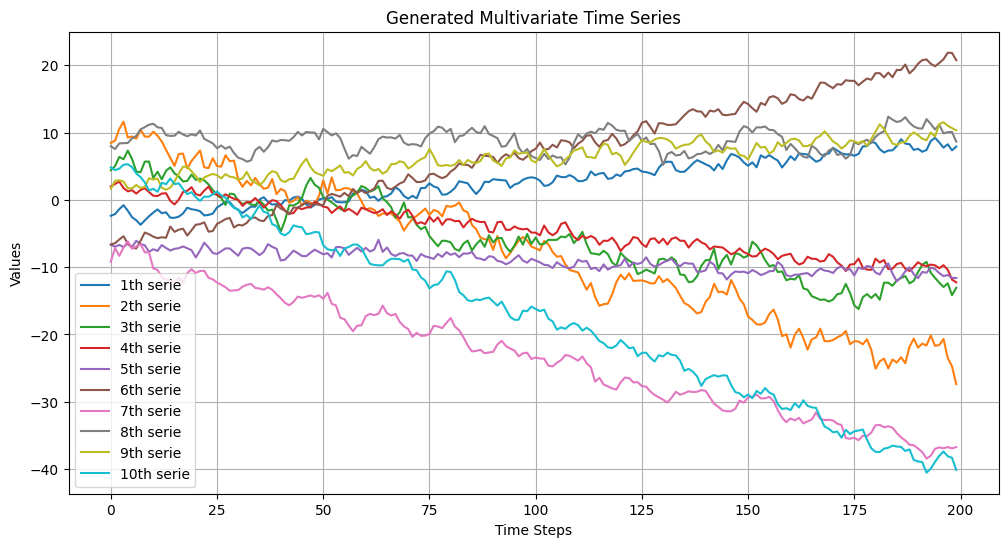

In [5]:
data_train = generate_multivariate_ts_1(
    n_variables=10,
    n_timesteps=200,
    noise_level=0.3,
    seed=42
)

plt.figure(figsize=(12, 6))
for i in range(data_train.shape[0]):
    plt.plot(data_train[i], label=f'{i+1}th serie')
plt.title('Generated Multivariate Time Series')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

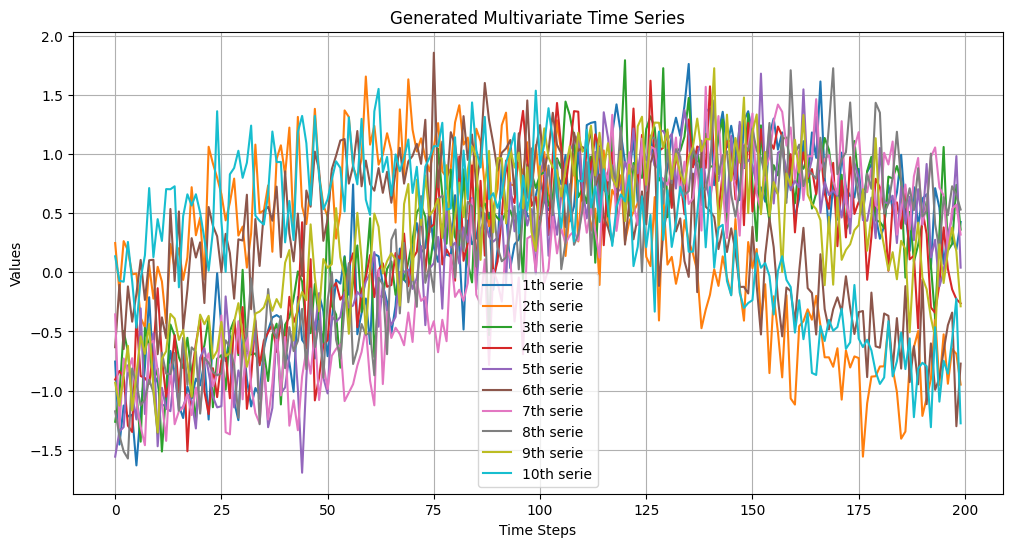

In [6]:
data_train = generate_multivariate_ts_3(
    n_variables=10,
    n_timesteps=200,
    noise_level=0.3,
    seed=42
)

plt.figure(figsize=(12, 6))
for i in range(data_train.shape[0]):
    plt.plot(data_train[i], label=f'{i+1}th serie')
plt.title('Generated Multivariate Time Series')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

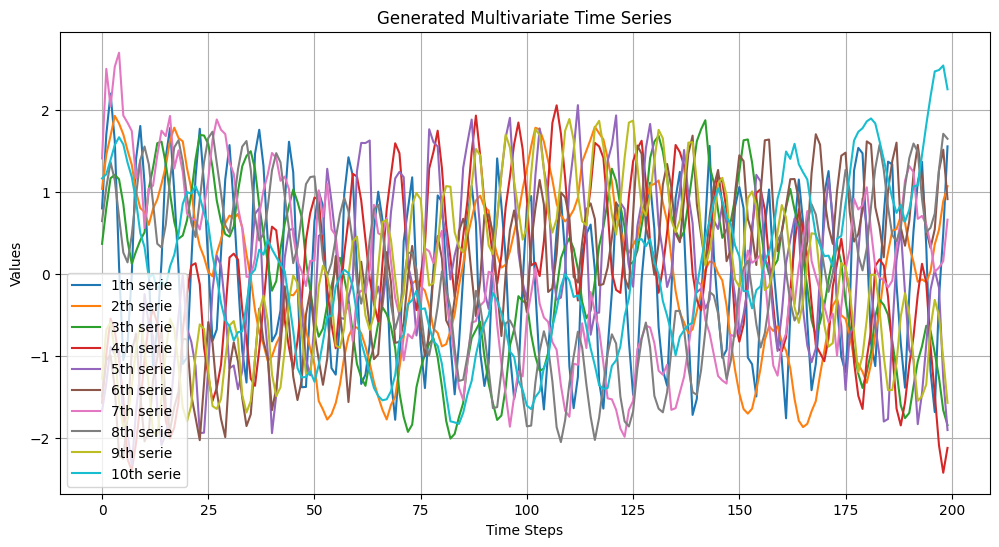

In [7]:
data_train = generate_multivariate_ts_2(
    n_variables=10,
    n_timesteps=200,
    noise_level=0.7,
    seed=42
)

plt.figure(figsize=(12, 6))
for i in range(data_train.shape[0]):
    plt.plot(data_train[i], label=f'{i+1}th serie')
plt.title('Generated Multivariate Time Series')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

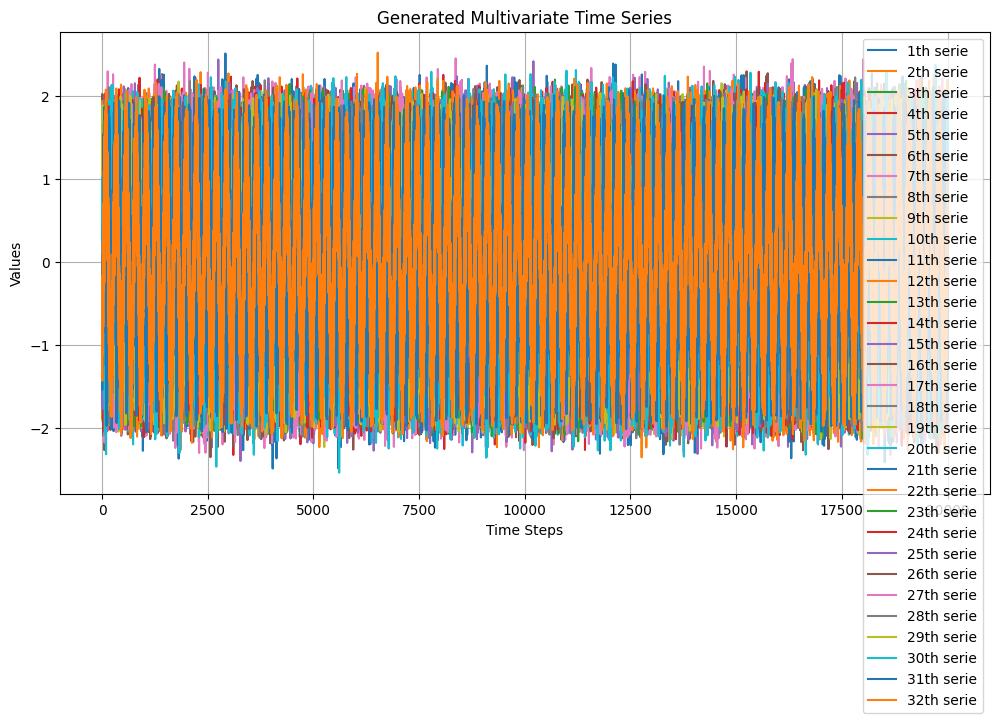

In [8]:
data_train = generate_multivariate_ts_2(
    n_variables=32,
    n_timesteps=20000,
    noise_level=0.7,
    seed=42
)

plt.figure(figsize=(12, 6))
for i in range(data_train.shape[0]):
    plt.plot(data_train[i], label=f'{i+1}th serie')
plt.title('Generated Multivariate Time Series')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
def create_anomalies(data, start_index=15000, duration_range=(50, 200), 
                    n_anomalies=5, anomaly_strength=1.5, seed=None):
    """
    Crée plusieurs anomalies dans les séries temporelles multivariées.
    
    Args:
        data: Matrice de shape (n_variables, n_timesteps)
        start_index: Index de début des anomalies
        duration_range: Tuple (min_duration, max_duration) pour la longueur des anomalies
        n_anomalies: Nombre d'anomalies à créer
        anomaly_strength: Force de l'anomalie (multiplicateur de l'écart-type)
        seed: Seed pour la reproductibilité
        
    Returns:
        np.array: Données avec anomalies
        list: Liste des informations sur les anomalies créées
    """
    if seed is not None:
        np.random.seed(seed)
    
    data_with_anomalies = data.copy()
    n_variables, n_timesteps = data.shape
    anomalies_info = []
    
    for i in range(n_anomalies):
        start_anomaly = np.random.randint(start_index, n_timesteps)
        series_num = np.random.randint(0, n_variables)
        duration = np.random.randint(duration_range[0], duration_range[1])

        end_anomaly = min(start_anomaly + duration, n_timesteps)
        actual_duration = end_anomaly - start_anomaly

        if actual_duration <= 0:
            i -= 1
            continue

        local_std = np.std(data[series_num, start_anomaly-100:start_anomaly])
        anomaly_type = np.random.choice(['spike', 'drift', 'level_shift', 'seasonal_break'])
        
        if anomaly_type == 'spike':
            spike_value = anomaly_strength * local_std * np.random.choice([-1, 1])
            data_with_anomalies[series_num, start_anomaly:end_anomaly] += spike_value

        elif anomaly_type == 'drift':
            drift_slope = anomaly_strength * local_std * 0.01 * np.random.choice([-1, 1])
            drift_values = np.arange(actual_duration) * drift_slope
            data_with_anomalies[series_num, start_anomaly:end_anomaly] += drift_values

        elif anomaly_type == 'level_shift':
            shift_value = anomaly_strength * local_std * np.random.choice([-1, 1])
            data_with_anomalies[series_num, start_anomaly:end_anomaly] += shift_value

        elif anomaly_type == 'seasonal_break':
            seasonal_amp = anomaly_strength * local_std * 0.5
            freq_change = np.random.uniform(0.5, 2.0)
            time_segment = np.arange(actual_duration)
            seasonal_anomaly = seasonal_amp * np.sin(2 * np.pi * freq_change * time_segment / 100)
            data_with_anomalies[series_num, start_anomaly:end_anomaly] += seasonal_anomaly

        anomalies_info.append({
            'series': series_num,
            'start_index': start_anomaly,
            'duration': actual_duration,
            'type': anomaly_type,
            'strength': anomaly_strength
        })
    
    return data_with_anomalies, anomalies_info

In [10]:
data_val_anomalous, anomalies_info = create_anomalies(
    data=data_train,
    start_index=15000,
    duration_range=(80, 150),
    n_anomalies=8,
    anomaly_strength=2.0,
    seed=43
)

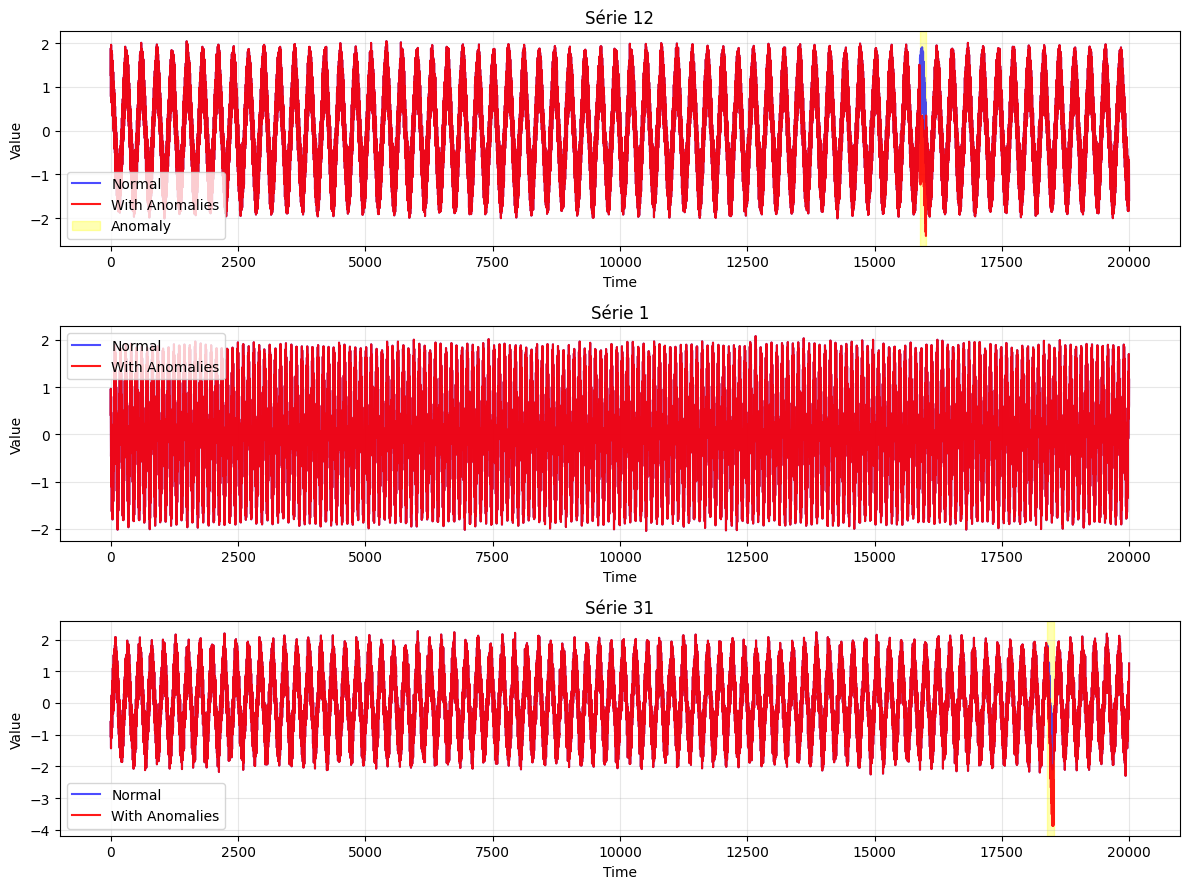

In [11]:
def plot_anomalies(data_normal, data_anomalous, anomalies_info, n_series_to_plot=3):
    """
    Visualise les séries avec anomalies.
    """
    n_variables, n_timesteps = data_normal.shape
    
    fig, axes = plt.subplots(n_series_to_plot, 1, figsize=(12, 3*n_series_to_plot))
    if n_series_to_plot == 1:
        axes = [axes]
    
    series_to_plot = np.random.choice(n_variables, n_series_to_plot, replace=False)
    
    for i, series_num in enumerate(series_to_plot):
        axes[i].plot(data_normal[series_num], 'b-', alpha=0.7, label='Normal')
        axes[i].plot(data_anomalous[series_num], 'r-', alpha=0.9, label='With Anomalies')
        
        for anomaly in anomalies_info:
            if anomaly['series'] == series_num:
                start = anomaly['start_index']
                end = start + anomaly['duration']
                axes[i].axvspan(start, end, color='yellow', alpha=0.3, label='Anomaly' if i == 0 else "")
        
        axes[i].set_title(f'Série {series_num}')
        axes[i].set_xlabel('Time')
        axes[i].set_ylabel('Value')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_anomalies(data_train, data_val_anomalous, anomalies_info, n_series_to_plot=3)

### 2. Generate "correlation" matrixes from thosee times series.

In [12]:
def generate_signature_matrix(
    data: np.ndarray,
    win_size: list[int] = [10, 30, 60],
    min_time: int = 0,
    max_time: int = None,
    gap_time: int = 10,
    normalize: bool = True,
    save_path: str = None
) -> np.ndarray:
    """
    Generates multi-scale signature matrices from multivariate time series.
    
    Args:
        data: Input data in the form (n_sensors, n_timesteps)
        win_size: List of window sizes
        min_time: Starting time point
        max_time: Ending time point (if None, uses total length)
        gap_time: Interval between segments
        normalize: If True, applies min-max normalization
        save_path: Path to save matrices (if None, no save)
    
    Returns:
        4D array of signature matrices with shape [time, len(win_sizes), n_sensors, n_sensors]
    """
    if max_time is None:
        max_time = data.shape[1]

    sensor_n = data.shape[0]
    time_steps = (max_time - min_time) // gap_time
    n_win = len(win_size)
    
    # Min-Max normalization
    if normalize:
        min_val = np.min(data, axis=1, keepdims=True)
        max_val = np.max(data, axis=1, keepdims=True)
        data = (data - min_val) / (max_val - min_val + 1e-6)
    
    # Initialize 4D array [time, n, n, 3]
    result = np.zeros((time_steps, n_win, sensor_n, sensor_n))
    
    for w_idx, win in enumerate(win_size):
        print(f"Generating signature matrices with window {win}...")
        
        for t_idx, t in enumerate(range(min_time, max_time, gap_time)):
            if t < win:  # Not enough data for the window
                mat = np.zeros((sensor_n, sensor_n))
            else:
                segment = data[:, t-win:t]
                mat = np.zeros((sensor_n, sensor_n))
                
                for i in range(sensor_n):
                    for j in range(i, sensor_n):
                        mat[i,j] = np.inner(segment[i], segment[j]) / win
                        mat[j,i] = mat[i,j]  # Symmetry
                        
            result[t_idx, w_idx, :, :] = mat
        
        if save_path:
            np.save(f"{save_path}/matrix_win_{win}.npy", result[:,w_idx,:,:])
    
    print("Signature matrix generation completed!")
    return result

In [13]:
win_size = [10, 30, 60]
min_time = 0
max_time = None
gap_time = 10
normalize = True

signature_matrices = generate_signature_matrix(
        data=data_train,
        win_size=win_size,
        min_time=min_time,
        max_time=max_time,
        gap_time=gap_time,
        normalize=normalize,
        save_path=None
    )

Generating signature matrices with window 10...
Generating signature matrices with window 30...
Generating signature matrices with window 60...
Signature matrix generation completed!


In [14]:
from matplotlib.gridspec import GridSpec

def plot_signature_matrices(
    matrix_4d: np.ndarray,
    win_sizes: list[int] = [10, 30, 60], 
    gap_time: int = 10, 
    sample_times: list[int] = [30, 100, 200],
    figsize: tuple = (12, 8)
) -> None:
    """
    Visualizes multi-scale signature matrices from 4D array [time, len(win_sizes), n, n].
    
    Args:
        matrix_4d: 4D array of signature matrices with shape [time, len(win_sizes), n, n]
        win_sizes: List of window sizes corresponding to the win channels
        gap_time: Time step between segments
        sample_times: Times to visualize (e.g., [start, middle, end] = [max(win_sizes), len(time)/2, len(time)])
        figsize: Figure dimensions

    Returns:
        None: Displays the signature matrices
    """
    # Entries validation
    if matrix_4d.ndim != 4:
        raise ValueError("Input matrix must be 4D array [time, len(win_sizes), n, n]")
    
    n_win = len(win_sizes)
    n_samples = len(sample_times)
    
    # Create grid with correct dimensions
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(n_win, n_samples + 1, 
                 width_ratios=[1]*n_samples + [0.05],
                 height_ratios=[1]*n_win)

    # Find global min/max for consistent color scaling
    vmin, vmax = np.percentile(matrix_4d, [5, 95])

    # Plot signature matrices
    for i, win_size in enumerate(win_sizes):
        for j, t in enumerate(sample_times):
            ax = plt.subplot(gs[i, j])
            
            # Calculate matrix index
            matrix_idx = t // gap_time
            if matrix_idx >= matrix_4d.shape[0]:
                matrix_idx = -1  # Use last available matrix
                
            # Get the matrix for this window size and time
            mat = matrix_4d[matrix_idx, i, :, :]
            
            # Plot matrix
            im = ax.imshow(mat, cmap='coolwarm', vmin=vmin, vmax=vmax)
            ax.set_title(f"t = {t}\nw = {win_size}", fontsize=10)
            ax.set_xticks([])
            ax.set_yticks([])
            
            # Add sensor labels on last row and first column
            if i == n_win - 1:
                ax.set_xlabel(f"Sensor {j+1}", fontsize=9)
            if j == 0:
                ax.set_ylabel(f"Scale {i+1}", fontsize=9)

    # Add colorbar
    cax = plt.subplot(gs[:, -1])
    plt.colorbar(im, cax=cax, label="Correlation")
    
    plt.suptitle("Multi-scale Signature Matrices", fontsize=14, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

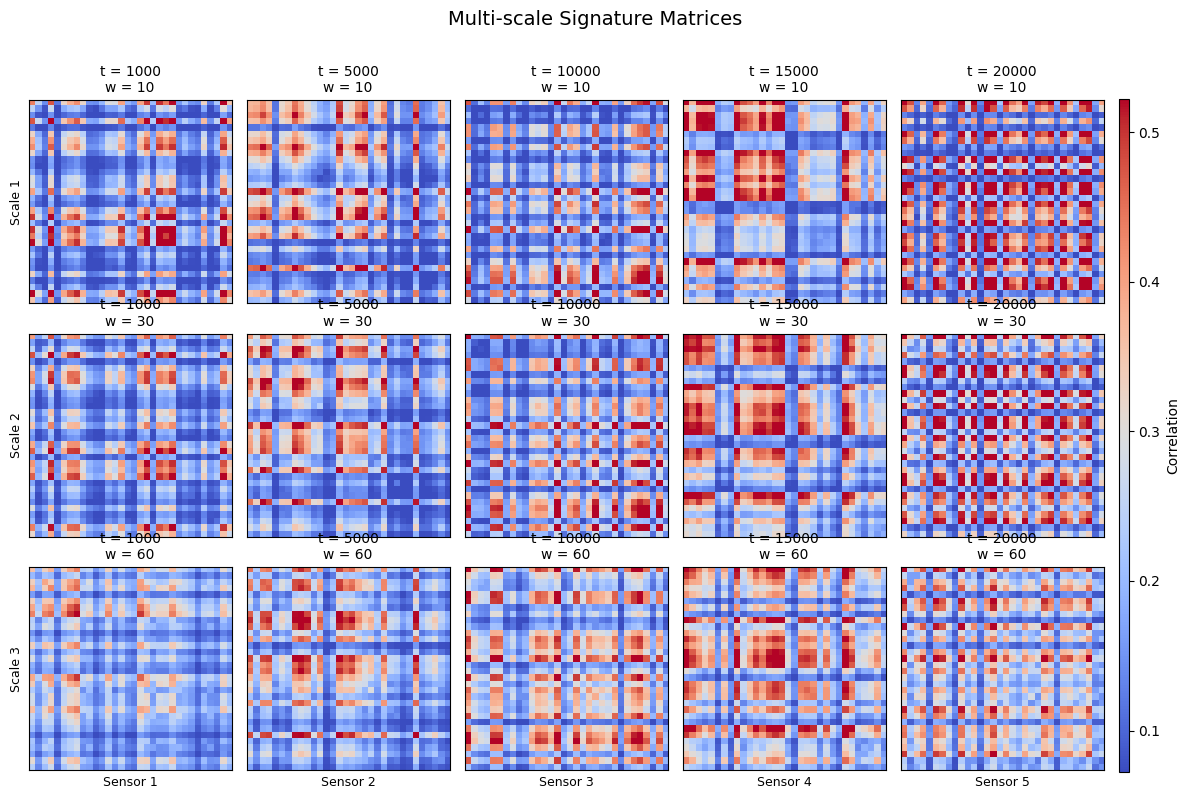

In [15]:
sample_times = [1000, 5000, 10000, 15000, 20000]

plot_signature_matrices(
    matrix_4d=signature_matrices,
    win_sizes=win_size,
    gap_time=gap_time,
    sample_times=sample_times,
    figsize=(12, 8)
)

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
# imageio to register it
# import imageio

def create_signature_matrix_animation(
    matrix_4d: np.ndarray,
    window_index: int,
    win_size: int,
    gap_time: int = 10,
    output_path: str = "signature_animation.gif",
    fps: int = 10,
    figsize: tuple = (8, 6),
    dpi: int = 100
) -> HTML:
    """
    Creates an animation of signature matrices over time for a specific window.
    
    Args:
        matrix_4d: 4D array of signature matrices with shape [time, len(win_sizes), n, n]
        window_index: Index of the window to animate
        win_size: Window size (for title)
        gap_time: Time step between segments
        output_path: Path to save the GIF
        fps: Frames per second for animation
        figsize: Figure dimensions
        dpi: Resolution for output
    """
    # Entries validation
    if matrix_4d.ndim != 4:
        raise ValueError("Input matrix must be 4D array [time, len(win_sizes), n, n]")
    if window_index not in [i for i in range(matrix_4d.shape[1])]:
        raise ValueError("window_index must be in window range [0, 1, ..., n-1]")
    
    # Extract matrices and setup figure
    window_matrices = matrix_4d[:, window_index, :, :]
    n_frames = window_matrices.shape[0]
    
    # Create figure with constrained layout
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi, constrained_layout=True)
    
    # Global color scale
    vmin, vmax = np.percentile(window_matrices, [5, 95])
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    
    # Create initial plot and colorbar
    im = ax.imshow(window_matrices[0], cmap='coolwarm', norm=norm)
    ax.set_title(f"Signature Matrix (Window size: {win_size})\nTime: 0")
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Add single colorbar (outside the axes)
    cbar = fig.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label("Correlation")

    def update(frame):
        """Update function for animation"""
        im.set_array(window_matrices[frame])
        ax.set_title(f"Signature Matrix (Window size: {win_size})\nTime: {frame * gap_time}")
        return [im]

    # Create animation
    anim = FuncAnimation(
        fig,
        update,
        frames=min(n_frames, 200),  # Limit to 100 frames max for performance
        interval=1000/fps,  # ms between frames
        blit=True
    )
    
    # Register the animation with imageio
    # anim.save(output_path, writer='pillow', fps=fps)
    # plt.close(fig)
    # print(f"Animation saved to {output_path}")
    
    # Plot the animation in Jupyter Notebook
    plt.close(fig)  # Prevent double display
    return HTML(anim.to_jshtml())

In [ ]:
create_signature_matrix_animation(
    matrix_4d=signature_matrices,
    window_index=0,
    win_size=10,
    gap_time=10,
    output_path="signature_animation_window10.gif",
    fps=5,
    figsize=(8, 6),
    dpi=100
)

In [ ]:
create_signature_matrix_animation(
    matrix_4d=signature_matrices,
    window_index=1,
    win_size=30,
    gap_time=10,
    output_path="signature_animation_window30.gif",
    fps=5,
    figsize=(8, 6),
    dpi=100
)

In [ ]:
create_signature_matrix_animation(
    matrix_4d=signature_matrices,
    window_index=2,
    win_size=60,
    gap_time=10,
    output_path="signature_animation_window60.gif",
    fps=5,
    figsize=(8, 6),
    dpi=100
)

### 3. Modèle MSCRED

1. Conv_LSTM unité
2. Conv_LSTM multicouche
3. Attention blocs
4. CNN encoder
5. Conv_LSTM batché
6. CNN decoder
7. MSCRED total
8. Loss adaptée
9. MSCRED total

In [16]:
import torch
import torch.nn as nn

from collections import deque
import os

In [17]:
print("Torch version? ", torch.__version__)
print("Cuda?          ", torch.cuda.is_available())

Torch version?  2.2.1+cu121
Cuda?           True


In [18]:
if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    print(f"GPU number : {device_count}")

    for i in range(device_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No NVIDIA GPU is available for PyTorch.")

GPU number : 2
GPU 0: Tesla T4
GPU 1: Tesla T4


In [19]:
# We want to force the use of one specific GPU if available and only one.
# Indeed, the batchs must be treated in chronologic order, due to the ConvLSTM module and the time deque between batches.

if torch.cuda.is_available():
    if torch.cuda.device_count() > 1:
        torch.cuda.set_device(0)
        device = torch.device("cuda:0")
    else:
        device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print("Device =", device)

Device = cuda:0


In [40]:
## Convolutional Long-Short Term Memory (ConvLSTM) Cell
class ConvLSTMCell(nn.Module):
    """
    Convolutional LSTM cell for processing spatio-temporal data.
    The discrepancy between the ConvLSTM and simple LSTM lies in the use of convolutional operations instead of fully connected layers,
    allowing the ConvLSTM to capture spatial hierarchies in the data.

    Functions:
        __init__: Initializes the ConvLSTM cell with input channels, hidden channels, and kernel size.
        forward: Performs the forward pass of the ConvLSTM cell.
        init_hidden: Initializes the hidden and cell states for the ConvLSTM cell.

    Attributes:
        input_channels: Number of input channels.
        hidden_channels: Number of hidden channels in the hidden state.
        kernel_size: Size of the convolutional kernel in the LSTM workflow.
        num_features: Number of features in the ConvLSTM cell (4 for input, forget, cell, output gates).
        padding: Padding size for the convolutional layers. The padding is calculated based on the kernel size.
        Wxi, Whi, Wxf, Whf, Wxc, Whc, Wxo, Who: Convolutional layers for input, forget, and output gates regarding the input and the hidden states.
        Wci, Wcf, Wco: Cell state weights for input, forget, and output gates regarding the cell state(initialized to None).
    """
    def __init__(
            self, 
            input_channels: int, 
            hidden_channels: int, 
            kernel_size: int | tuple
            ) -> None:
        super().__init__()

        assert hidden_channels % 2 == 0

        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        # self.num_features = 4

        self.padding = int((kernel_size - 1) / 2)

        self.Wxi = nn.Conv2d(in_channels=self.input_channels,  out_channels=self.hidden_channels, kernel_size=self.kernel_size, stride=1, padding=self.padding, bias=True )
        self.Whi = nn.Conv2d(in_channels=self.hidden_channels, out_channels=self.hidden_channels, kernel_size=self.kernel_size, stride=1, padding=self.padding, bias=False)
        self.Wxf = nn.Conv2d(in_channels=self.input_channels,  out_channels=self.hidden_channels, kernel_size=self.kernel_size, stride=1, padding=self.padding, bias=True )
        self.Whf = nn.Conv2d(in_channels=self.hidden_channels, out_channels=self.hidden_channels, kernel_size=self.kernel_size, stride=1, padding=self.padding, bias=False)
        self.Wxc = nn.Conv2d(in_channels=self.input_channels,  out_channels=self.hidden_channels, kernel_size=self.kernel_size, stride=1, padding=self.padding, bias=True )
        self.Whc = nn.Conv2d(in_channels=self.hidden_channels, out_channels=self.hidden_channels, kernel_size=self.kernel_size, stride=1, padding=self.padding, bias=False)
        self.Wxo = nn.Conv2d(in_channels=self.input_channels,  out_channels=self.hidden_channels, kernel_size=self.kernel_size, stride=1, padding=self.padding, bias=True)
        self.Who = nn.Conv2d(in_channels=self.hidden_channels, out_channels=self.hidden_channels, kernel_size=self.kernel_size, stride=1, padding=self.padding, bias=False)

        self.Wci = None
        self.Wcf = None
        self.Wco = None

    def forward(
            self, 
            x: torch.Tensor, 
            h: torch.Tensor, 
            c: torch.Tensor
            ) -> tuple[torch.Tensor]:
        """
        Forward pass of the ConvLSTM cell.

        Args:
            x: Input tensor of shape (batch_size, input_channels, height, width)
            h: Hidden state tensor of shape (batch_size, hidden_channels, height, width)
            c: Cell state tensor of shape (batch_size, hidden_channels, height, width)

        Returns:
            Tuple of updated hidden state and cell state tensors, shape (batch_size, hidden_channels, height, width)
        """
        ci = torch.sigmoid(self.Wxi(x) + self.Whi(h) + c * self.Wci)
        cf = torch.sigmoid(self.Wxf(x) + self.Whf(h) + c * self.Wcf)
        cc = cf * c + ci * torch.tanh(self.Wxc(x) + self.Whc(h))
        co = torch.sigmoid(self.Wxo(x) + self.Who(h) + cc * self.Wco)
        ch = co * torch.tanh(cc)
        return ch, cc

    def init_hidden(
            self,
            batch_size: int, 
            hidden: int, 
            shape: tuple[int], 
            device: str
            ) -> tuple[torch.Tensor]:
        """
        Initializes weight for the convLSTM cell. In two parts:
            - The weight matrices for the Input, Forget, and Output gates regarding the cell state (Wci, Wcf, Wco). 
              These are initialized to zero tensors, in order to limit the influence of the cell state (and its gradient) in first iterations.
            
            - The very first hidden state and cell state (h and c). h and c represent respectively the short and long-term memory.
              Those are also initialized to zero tensors, because no history is available at the first time step.
        
        This is done only once, at the first step of the forward pass.

        Args:
            batch_size: Size of the batch
            hidden: Number of hidden channels
            shape: Shape of the input (height, width)
            device: Device to place the tensors on

        Returns:
            Tuple of initialized hidden state and cell state tensors.
        """
        if self.Wci is None:
            self.Wci = torch.zeros(1, hidden, shape[0], shape[1], device=device)
            self.Wcf = torch.zeros(1, hidden, shape[0], shape[1], device=device)
            self.Wco = torch.zeros(1, hidden, shape[0], shape[1], device=device)
        else:
            assert shape[0] == self.Wci.shape[2], 'Input Height Mismatched!'
            assert shape[1] == self.Wci.shape[3], 'Input Width Mismatched!'
        return (torch.zeros(batch_size, hidden, shape[0], shape[1], device=device),
                torch.zeros(batch_size, hidden, shape[0], shape[1], device=device))


class ConvLSTM(nn.Module):
    # input_channels corresponds to the first input feature map
    # hidden state is a list of succeeding lstm layers.
    """
    Convolutional LSTM model for processing spatio-temporal data.
    A ConvLSTM model is a sequence of ConvLSTM cells that processes the input tensor over multiple steps.
    If len(hidden_channels) == 1, it behaves like a standard ConvLSTM cell alone.

    Functions:
        __init__: Initializes the ConvLSTM model with input channels, hidden channels, kernel size, step, and effective step.
        reset_hidden_state: Resets the hidden states h and c of the ConvLSTM model to zeros.
        forward: Performs the forward pass of the ConvLSTM model.

    Attributes:
        input_channels: Number of channels for the first input feature map. Correspond to the inputs of ConvLSTMCell.
        hidden_channels: List of hidden channels for each layer. Correspond to the outputs of ConvLSTMCell.
        kernel_size: Size of the convolutional kernel in Convolutional layers of the ConvLSTM cell.
        num_layers: Number of ConvLSTM layers.
        step: Number of steps to process in the forward pass.
        effective_step: List of effective steps to record outputs.
        _all_layers: List of all ConvLSTM cells in the model. Each are callable objects that refers to the corresponding ConvLSTM cell.
        next_hidden_state: List of next hidden states for each layer. Will be use for the next window pass on the ConvLSTM.
    """
    def __init__(
            self, 
            input_channels: int, 
            hidden_channels: list[int], 
            kernel_size: int | tuple, 
            step: int = 1, 
            effective_step: list[int] = [0, 1]
            ) -> None:
        super().__init__()
        assert step >= 1, "n_step must be at least 1 to find temporal dependencies and to register the next hidden state."

        self.input_channels = [input_channels] + hidden_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.num_layers = len(hidden_channels)
        self.step = step
        self.effective_step = effective_step

        self._all_layers = nn.ModuleList()
        for i in range(self.num_layers):
            cell = ConvLSTMCell(
                input_channels=self.input_channels[i],
                hidden_channels=self.hidden_channels[i],
                kernel_size=self.kernel_size
            )
            self._all_layers.append(cell)

        self.next_hidden_state = [None] * self.num_layers

    def reset_hidden_state(self):
        """
        Reset the hidden state of the ConvLSTM model.
        For instance, when we start a new epoch in the training, we want to reset the hidden state.
        """
        self.next_hidden_state = [None] * self.num_layers

    def forward(
            self, 
            input: torch.Tensor,
            ) -> tuple[list[torch.Tensor], tuple[torch.Tensor]]:
        """
        Forward pass of the ConvLSTM model.
        A ConvLSTM model is a sequence of ConvLSTM cells that processes the input tensor over multiple steps.
        For each step, the input tensor is passed through all layers.
        Each layer is a ConvLSTM cell that takes the output of the previous layer as input.

        Args:
            input: Input tensor of shape (self.step, input_channels, height, width)

        Returns:
            Tuple containing:
                - List of output tensors for each effective step: [h_0, h_1, ..., h_step]
                - Tuple of the last hidden state and cell state tensors (h_lastlayer_laststep, c_lastlayer_laststep)
        
        Nota bene:
            We initialize the internal state (hidden and cell states) for each layer in the first step.
            And that for each time window (of size self.step). Whether the model is in training or inference mode, the internal states are reset.
            Indeed, as the time window are overlapping, the internal state of the
        """
        internal_state = []
        outputs = []

        input = input.unsqueeze(1) if input.dim() == 4 else input  # Ensure input is 5D: (step, 1, channels, height, width)
        
        for step_idx in range(self.step):
            x = input[step_idx]

            for layer_idx, cell in enumerate(self._all_layers):
                if step_idx == 0:
                    if self.next_hidden_state[layer_idx] is None:
                        bsize, _, height, width = x.shape
                        h, c = cell.init_hidden(batch_size=bsize, hidden=self.hidden_channels[layer_idx], shape=(height, width), device=x.device)
                    else:
                        # if next_hidden_state is provided, use it
                        h, c = self.next_hidden_state[layer_idx]
                    internal_state.append((h, c))
                                   
                # do forward
                h, c = internal_state[layer_idx]
                new_h, new_c = cell(x, h, c)
                internal_state[layer_idx] = (new_h, new_c)
                # output of the current layer is the input for the next layer
                x = new_h

                ### if step_idx == 1 and not self.training: # <------- Uncomment this line to use persistant hidden states only during inference
                if step_idx == 1:      
                    # register the hidden state for the next time window
                    h_save, c_save = new_h.clone().detach(), new_c.clone().detach()
                    self.next_hidden_state[layer_idx] = (h_save, c_save)

            # only record effective steps of the last layer
            if step_idx in self.effective_step:
                outputs.append(new_h)

        return outputs, (new_h, new_c)

#### Test ConvLSTMCell

In [ ]:
batch_size = 1
input_channels = 3
height, width = 32, 32
kernel_size = 3
hidden_channels = 64
x = torch.randn(batch_size, input_channels, height, width).to(device)

convlstm_cell = ConvLSTMCell(
    input_channels=input_channels,
    hidden_channels=hidden_channels,
    kernel_size=kernel_size
).to(device)
h, c = convlstm_cell.init_hidden(batch_size, hidden_channels, (height, width), device)
new_h, new_c = convlstm_cell(x, h, c)

print("Shape of input x:", x.shape)
print("\nShape of first hidden state h:    ", h.shape)
print("Shape of first cell   state c:    ", c.shape)
print("Shape of new   hidden state new_h:", new_h.shape)
print("Shape of new   cell   state new_c:", new_c. shape)
assert new_h.shape == (batch_size, hidden_channels, height, width)
assert new_c.shape == new_h.shape
print("\nAll shapes are correct!")

#### Test ConvLSTM

In [ ]:
batch_size = 1
input_channels = 3
hidden_channels = [32, 64, 128]
height, width = 32, 32
kernel_size = 3
steps = 5
effective_step = [0, 1, 2, 3, 4]

x = torch.randn(steps, input_channels, height, width).to(device)

convlstm = ConvLSTM(
    input_channels=input_channels,
    hidden_channels=hidden_channels,
    kernel_size=kernel_size,
    step=steps,
    effective_step=effective_step
).to(device)
outputs, (final_h, final_c) = convlstm(x)


print("Shape of input x:", x.shape)
print("Number of ConvLSTM layers:", len(convlstm.hidden_channels))
print("Number of ConvLSTM layers 2:", convlstm.num_layers)
print("Number of recorded outputs:", len(outputs))
print("Effective steps:", convlstm.effective_step)
print("Layer type:", type(convlstm._all_layers[0]))

print("\nShape of output tensors:")
for i, step in enumerate(convlstm.effective_step):
    print(f"Output of step {step}:")
    print("Shape:", outputs[i].shape)
assert outputs[i].shape == (batch_size, hidden_channels[-1], height, width)

print("\nShape of last hidden state final_h:", final_h.shape)
print("Shape of last cell state final_c:", final_c.shape)
assert final_h.shape == (batch_size, hidden_channels[-1], height, width)
assert final_c.shape == final_h.shape

print("\nAll shapes are correct!")

In [21]:
## Attention mechanism for ConvLSTM output
def attention(
        ConvLstm_out: torch.Tensor,
        rescale_factor: float = 5.0
        ) -> torch.Tensor:
    """
    Attention mechanism for ConvLSTM output (Vectorized)
    This implementation build a causal "by construction" attention mechanism. "By construction" because we only give passed informations.

    Args:
        ConvLstm_out: Tensor output from the ConvLSTM layer. Shape (n_effective_timestep, channels, height, width)
        n: Number of steps to consider for attention weighting.

    Returns:
        Tensor: The output after applying the attention mechanism. Shape (channels, height, width)

    Nota bene:
        The rescale_factor is used to normalize the similarity scores after the dot product of the 
        hidden states and before the softmax function.
        The value of 5 is empirically determined.
        This value is a compromise between producing uniform attention weights (large rescale_factor = all weights are the same order) 
        and producing a sharp distribution in weights (small rescale_factor = one weight dominates) with the softmax function.
    
    Post Scriptum: 
        In the future, we could replace this attention mechanism with a more sophisticated one, such as a query-key attention mechanism.
    """
    assert rescale_factor > 0, "Rescale factor must be positive and non zero"

    last_step = ConvLstm_out[-1]
    similarities = torch.einsum('tchw,chw->t', ConvLstm_out, last_step) / rescale_factor
    attention_weights = torch.softmax(similarities, dim=0)
    ConvLstm_out_weighted = torch.einsum('t,tchw->chw', attention_weights, ConvLstm_out)
    return ConvLstm_out_weighted

#### Test attention function

In [ ]:
n_effective_timestep = 5
batch_size = 1
channels = 64
height = 32
width = 32

conv_lstm_out = torch.randn(n_effective_timestep, channels, height, width)
print("Shape of ConvLSTM output tensor:", conv_lstm_out.shape)

attention_output = attention(conv_lstm_out)

print("Attention output shape:", attention_output.shape)
assert attention_output.shape == (channels, height, width), f"Expected shape: {(channels, height, width)}, obtained: {attention_output.shape}"
assert not torch.isnan(attention_output).any(), "Result contains NaN values"
assert not torch.isinf(attention_output).any(), "Result contains infinite values"

for rescale in [0.1, 1.0, 5.0, 10.0, 100.0]:
    try:
        output = attention(conv_lstm_out, rescale_factor=rescale)
        assert output.shape == (channels, height, width)
    except Exception as e:
        assert False, f"Error with rescale_factor={rescale}: {str(e)}"

print("\nAll tests passed with success!")

In [22]:
## Encoder-Decoder modules
class CnnEncoder(nn.Module):
    """
    CNN Encoder module

    This module applies a series of convolutional layers to the input data.
    Shapes: (batch_size, 32,  height,    width)    after conv1 (stride 1)
            (batch_size, 64,  height//2, width//2) after conv2 (stride 2)
            (batch_size, 128, height//4, width//4) after conv3 (stride 2)
            (batch_size, 256, height//8, width//8) after conv4 (stride 2)
    """
    def __init__(
            self, 
            in_channels_encoder: int = 3, 
            deep_channel_sizes: list[int] = [32, 64, 128, 256]
            ) -> None:
        """
        We have chosen SELU() activation function for its self-normalizing properties.

        Advices:
            - in_channels = [in_channels_encoder, 32, 64, 128]
            - out_channels = [32, 64, 128, 256]
            - kernel_sizes = [3, 3, 2, 2]
            - stride must be (2, 2) for the first three layers, (1, 1) for the last layer (no dimension reduction)
            - padding must be (0, 0) for the last layer (no operations after the last layer), (1, 1) for the others
        """
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels_encoder, 
                      out_channels=deep_channel_sizes[0], 
                      kernel_size=3, stride=(1, 1), padding=1),
            nn.SELU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=deep_channel_sizes[0], 
                      out_channels=deep_channel_sizes[1], 
                      kernel_size=3, stride=(2, 2), padding=1),
            nn.SELU()
        )    
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=deep_channel_sizes[1], 
                      out_channels=deep_channel_sizes[2], 
                      kernel_size=2, stride=(2, 2), padding=0),
            nn.SELU()
        )   
        # self.conv4 = nn.Sequential(
        #     nn.Conv2d(in_channels=deep_channel_sizes[2], 
        #               out_channels=deep_channel_sizes[3], 
        #               kernel_size=2, stride=(2, 2), padding=0),
        #     nn.SELU()
        # )
    def forward(self, X: torch.Tensor) -> tuple[torch.Tensor]:
        """
        Forward pass for the CNN encoder

        Args:
            X (torch.Tensor): Input tensor

        Returns:
            tuple[torch.Tensor]: Output tensors from each convolutional layer
        """
        conv1_out = self.conv1(X)
        conv2_out = self.conv2(conv1_out)
        conv3_out = self.conv3(conv2_out)
        # conv4_out = self.conv4(conv3_out)
        return conv1_out, conv2_out, conv3_out#, conv4_out

class Conv_LSTM(nn.Module):
    """
    Convolutional LSTM module
    This module applies a series of ConvLSTM layers to the output of CnnEncoder.

    Functions:
        - __init__: Initializes the Conv_LSTM module.
        - forward: Defines the forward pass for the Conv_LSTM module.
        - _init_queue: Initializes the internal queues for the Conv_LSTM module.
        - _update_queues: Updates the internal queues with the latest CnnEncoder output.
    """
    def __init__(
            self,
            deep_channel_sizes: list[int] = [32, 64, 128, 256],
            num_layers: int = 1,
            n_timesteps: int = 5, 
            n_effective_timesteps: list = [1, 2, 3, 4]
            ) -> None:
        super().__init__()
        self.conv1_lstm = ConvLSTM(input_channels=deep_channel_sizes[0], 
                                   hidden_channels=[deep_channel_sizes[0]]*num_layers, 
                                   kernel_size=3, 
                                   step=n_timesteps, effective_step=n_effective_timesteps)
        self.conv2_lstm = ConvLSTM(input_channels=deep_channel_sizes[1], 
                                   hidden_channels=[deep_channel_sizes[1]]*num_layers, 
                                   kernel_size=3, 
                                   step=n_timesteps, effective_step=n_effective_timesteps)
        self.conv3_lstm = ConvLSTM(input_channels=deep_channel_sizes[2], 
                                   hidden_channels=[deep_channel_sizes[2]]*num_layers, 
                                   kernel_size=3, 
                                   step=n_timesteps, effective_step=n_effective_timesteps)
        # self.conv4_lstm = ConvLSTM(input_channels=deep_channel_sizes[3], 
        #                            hidden_channels=[deep_channel_sizes[3]]*num_layers, 
        #                            kernel_size=3, 
        #                            step=n_timesteps, effective_step=n_effective_timesteps)

        self.n_timesteps = n_timesteps
        self.queue1 = deque(maxlen=n_timesteps)
        self.queue2 = deque(maxlen=n_timesteps)
        self.queue3 = deque(maxlen=n_timesteps)
        # self.queue4 = deque(maxlen=n_timestep)

    def _init_queue(
            self, 
            queue: deque, 
            in_shape: tuple, 
            steps: int,
            device: str
            ) -> None:
        """
        Initialize the queues with zeros for the first `steps - 1` timesteps.

        Args:
            queue (deque): Queue to initialize
            in_shape (tuple): Shape of the input tensor
            steps (int): Number of timesteps
            device (str): Device to place the tensors on

        Nota bene:
            The zeros tensors are created with `requires_grad=False` to avoid unnecessary gradient computations.
        """
        queue.clear()
        for _ in range(steps):
            # resize to be shape [steps, C, H, W]
            queue.append(torch.zeros(in_shape[1:], device=device, requires_grad=False))

    def _update_queues(self, x_conv1_out: torch.Tensor, x_conv2_out: torch.Tensor, x_conv3_out: torch.Tensor, x_conv4_out: torch.Tensor = 0) -> None:
        """
        Update the queues with the latest CnnEncoder output with this scheme:
            - Theoretically, in the last queue, all tensors are detached form autograd, except for the most recent one.
            - We pop the recent tensors from the queues and detach them from the computation graph.
            - We add this detached tensor back to the queue.
            - We add the new tensor to the queue.
            - This new tensor is attached to the computation graph.
            - Thanks to maxlen deque's behavior, we ensure that the queue always contains the n_timesteps most recent tensors.

        Args:
            x_convi_out (torch.Tensor): Output from the i_th CnnEncoder layer.
        """
        # resize to be shape [steps, C, H, W]
        assert len(self.queue1) == self.n_timesteps, "Queue length must match n_timesteps"
        assert len(self.queue2) == self.n_timesteps, "Queue length must match n_timesteps"
        assert len(self.queue3) == self.n_timesteps, "Queue length must match n_timesteps"
        # assert len(self.queue4) == self.n_timesteps, "Queue length must match n_timesteps"

        old_grad_tensor1 = self.queue1.pop()
        old_grad_tensor2 = self.queue2.pop()
        old_grad_tensor3 = self.queue3.pop()
        # old_grad_tensor4 = self.queue4.pop()
        
        old_grad_tensor1 = old_grad_tensor1.detach()
        old_grad_tensor2 = old_grad_tensor2.detach()
        old_grad_tensor3 = old_grad_tensor3.detach()
        # old_grad_tensor4 = old_grad_tensor4.detach()

        self.queue1.append(old_grad_tensor1)
        self.queue2.append(old_grad_tensor2)
        self.queue3.append(old_grad_tensor3)
        # self.queue4.append(old_tensor4)

        self.queue1.append(x_conv1_out)
        self.queue2.append(x_conv2_out)
        self.queue3.append(x_conv3_out)
        # self.queue4.append(x_conv4_out)

    def forward(self, conv1_out: torch.Tensor, conv2_out: torch.Tensor, conv3_out: torch.Tensor, conv4_out: torch.Tensor = 0) -> tuple[torch.Tensor]:
        """
        ConvLSTM forward pass
        convi_lstm_out is a tuple (outputs, (x, new_c))
            - output: the registered hidden state of effective_step list
            - (x, new_c): the hidden state and cell state for the last step
        Exemple of shape for conv2_lstm_out:
            output.shape = (batch_size, 64, height/2, width/2)
            x.shape = new_c.shape = (batch_size, 64, height/2, width/2)
        So convi_lstm_out[0][0] is the first element of output.

        Args:
            convi_out (torch.Tensor): Output from the ith convolutional layer
            conv4_out (torch.Tensor, optional): Output from the fourth convolutional layer

        Returns:
            Tuple[torch.Tensor]: Output tensors from each ConvLSTM layer
        """
        for queue, convX in [(self.queue1, conv1_out), (self.queue2, conv2_out), (self.queue3, conv3_out)]:
            if bool(queue) is False:
                self._init_queue(queue, convX.shape, self.n_timesteps, device=convX.device)

        conv1_lstm_out = torch.zeros_like(conv1_out).to(device=conv1_out.device)
        conv2_lstm_out = torch.zeros_like(conv2_out).to(device=conv2_out.device)
        conv3_lstm_out = torch.zeros_like(conv3_out).to(device=conv3_out.device)
        # conv4_lstm_out = torch.zeros_like(conv4_out).to(device=conv4_out.device)

        for batch_idx, (x_conv1, x_conv2, x_conv3) in enumerate(zip(conv1_out, conv2_out, conv3_out)):
            x_conv1 = x_conv1.to(conv1_out.device)
            x_conv2 = x_conv2.to(conv2_out.device)
            x_conv3 = x_conv3.to(conv3_out.device)
            # x_conv4 = x_conv4.to(conv4_out.device)

            self._update_queues(x_conv1, x_conv2, x_conv3)

            x_conv1_lstm_in = torch.stack(tuple(self.queue1), dim=0)
            x_conv2_lstm_in = torch.stack(tuple(self.queue2), dim=0)
            x_conv3_lstm_in = torch.stack(tuple(self.queue3), dim=0)
            # x_conv4_lstm_in = torch.stack(tuple(self.queue4), dim=0)

            x_conv1_lstm_out = self.conv1_lstm(x_conv1_lstm_in)
            x_conv1_lstm_out = attention(ConvLstm_out=torch.cat(x_conv1_lstm_out[0], dim=0))
            x_conv2_lstm_out = self.conv2_lstm(x_conv2_lstm_in)
            x_conv2_lstm_out = attention(ConvLstm_out=torch.cat(x_conv2_lstm_out[0], dim=0))
            x_conv3_lstm_out = self.conv3_lstm(x_conv3_lstm_in)
            x_conv3_lstm_out = attention(ConvLstm_out=torch.cat(x_conv3_lstm_out[0], dim=0))
            # x_conv4_lstm_out = self.conv4_lstm(x_conv4_lstm_in)
            # x_conv4_lstm_out = attention(ConvLstm_out=torch.cat(x_conv4_lstm_out[0], dim=0))
            
            conv1_lstm_out[batch_idx] = x_conv1_lstm_out
            conv2_lstm_out[batch_idx] = x_conv2_lstm_out
            conv3_lstm_out[batch_idx] = x_conv3_lstm_out
            # conv4_lstm_out[batch_idx] = x_conv4_lstm_out

        return conv1_lstm_out, conv2_lstm_out, conv3_lstm_out, #conv4_lstm_out

class CnnDecoder(nn.Module):
    """
    CNN Decoder module

    This module applies a series of transposed convolutional layers to the input data.
    Shapes: (batch_size, 128, height*2, width*2) after deconv4 (stride 2)
            (batch_size, 256, height*2, width*2) after first concatenation
            (batch_size, 64,  height*4, width*4) after deconv3 (stride 2)
            (batch_size, 128, height*4, width*4) after second concatenation
            (batch_size, 32,  height*8, width*8) after deconv2 (stride 2)
            (batch_size, 64,  height*8, width*8) after first concatenation
            (batch_size, 3,   height*8, width*8) after deconv1 (stride 1)
    """
    def __init__(
            self,
            in_channels_encoder: int = 3,
            deep_channel_sizes: list[int] = [32, 64, 128, 256]
            ) -> None:
        """
        We have chosen SELU() activation function for its self-normalizing properties.
        
        Advices:
            - in_channels = hidden_channels of the corresponding ConvLSTM layer + concatenation
                + if conv4_lstm_out is not None, [256, 256, 128, 64]
                + if conv4_lstm_out is None, [128, 128, 64]
            - out_channels
                + if conv4_lstm_out is not None, [128, 64, 32, encoder_in_channels]
                + if conv4_lstm_out is None, [64, 32, encoder_in_channels]
            - kernel_sizes = [2, 2, 3, 3]
            - stride must be (2, 2) for the first three layers, (1, 1) for the last layer (no dimension reduction)
            - padding must be (0, 0) for the first layer, (1, 1) for the others
            - output_padding must be (0, 0) for the first and last layer, (1, 1) for the others
        """
        super().__init__()
        deep_channel_sizes_decode = deep_channel_sizes[::-1]

        # self.deconv4 = nn.Sequential(
        #     nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2, padding=0, output_padding=0),
        #     nn.SELU()
        # )
        ### If conv4_lstm_out is not None, put in_channels(self.deconv3)=256, else 128
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=deep_channel_sizes_decode[0], 
                               out_channels=deep_channel_sizes_decode[1], 
                               kernel_size=2, stride=2, 
                               padding=0, output_padding=0),
            nn.SELU()
        )
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=deep_channel_sizes_decode[1]*2, 
                               out_channels=deep_channel_sizes_decode[2], 
                               kernel_size=3, stride=2, 
                               padding=1, output_padding=1),
            nn.SELU()
        )
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=deep_channel_sizes_decode[2]*2, 
                               out_channels=in_channels_encoder, 
                               kernel_size=3, stride=1, 
                               padding=1, output_padding=0),
            nn.SELU()
        )

    def forward(self, conv1_lstm_out: torch.Tensor, conv2_lstm_out: torch.Tensor, conv3_lstm_out: torch.Tensor, conv4_lstm_out: torch.Tensor = 0) -> torch.Tensor:
        """
        Forward pass for the CNN decoder

        Args:
            conv1_lstm_out (torch.Tensor): Output from the first LSTM layer
            conv2_lstm_out (torch.Tensor): Output from the second LSTM layer
            conv3_lstm_out (torch.Tensor): Output from the third LSTM layer
            conv4_lstm_out (torch.Tensor, optional): Output from the fourth LSTM layer
        Shapes:
            - conv1_lstm_out: (batch_size, 32, height, width)
            - conv2_lstm_out: (batch_size, 64, height, width)
            - conv3_lstm_out: (batch_size, 128, height, width)
            - conv4_lstm_out: (batch_size, 256, height, width)

        Returns:
            torch.Tensor: Output tensor from the decoder. Shape (batch_size, in_channels_encoder, height, width)
        """
        # deconv4 = self.deconv4(conv4_lstm_out)
        # deconv4_concat = torch.cat((deconv4, conv3_lstm_out), dim = 1)
        deconv3 = self.deconv3(conv3_lstm_out)      #deconv3 = self.deconv3(deconv4_concat)
        deconv3_concat = torch.cat((deconv3, conv2_lstm_out), dim = 1)
        deconv2 = self.deconv2(deconv3_concat)
        deconv2_concat = torch.cat((deconv2, conv1_lstm_out), dim = 1)
        deconv1 = self.deconv1(deconv2_concat)
        return deconv1
    

In [ ]:
class Conv_LSTM_2_a_revoir(nn.Module):
    """
    Convolutional LSTM module vectorialisée
    Utilise des buffers PyTorch pour maintenir l'état temporel entre les batches

    PAS ENCORE FINI, à reprendre
    Il faudra alors modifier l'Attention pour prendre en compte le batch_size.
    """
    
    def __init__(self, n_timesteps: int = 5, n_effective_timesteps: list = [1, 2, 3, 4]) -> None:
        super().__init__()
        self.n_timesteps = n_timesteps
        self.n_effective_timesteps = n_effective_timesteps
        
        # ConvLSTM layers
        self.conv1_lstm = ConvLSTM(input_channels=32, hidden_channels=[32], 
                                   kernel_size=3, step=n_timesteps, effective_step=n_effective_timesteps)
        self.conv2_lstm = ConvLSTM(input_channels=64, hidden_channels=[64], 
                                   kernel_size=3, step=n_timesteps, effective_step=n_effective_timesteps)
        self.conv3_lstm = ConvLSTM(input_channels=128, hidden_channels=[128], 
                                   kernel_size=3, step=n_timesteps, effective_step=n_effective_timesteps)
        
        # Buffers pour stocker l'état temporel (seront initialisés lors du premier forward)
        self.register_buffer('queue1', None)
        self.register_buffer('queue2', None)
        self.register_buffer('queue3', None)
        self.register_buffer('ptr', torch.tensor(0, dtype=torch.long))
        
    def _init_queues(self, conv1_shape: torch.Size, conv2_shape: torch.Size, conv3_shape: torch.Size) -> None:
        device = self.ptr.device
        
        # Initialisation des queues avec des zéros
        self.queue1 = torch.zeros(self.n_timesteps, *conv1_shape[1:], device=device)
        self.queue2 = torch.zeros(self.n_timesteps, *conv2_shape[1:], device=device)
        self.queue3 = torch.zeros(self.n_timesteps, *conv3_shape[1:], device=device)
        
    def _update_queues(self, conv1_out: torch.Tensor, conv2_out: torch.Tensor, conv3_out: torch.Tensor) -> None:
        batch_size = conv1_out.size(0)
        
        # Détacher les anciennes valeurs (sauf la position actuelle)
        with torch.no_grad():
            # Mise à jour circulaire
            self.queue1[self.ptr] = conv1_out.detach().mean(dim=0)  # Moyenne sur le batch
            self.queue2[self.ptr] = conv2_out.detach().mean(dim=0)
            self.queue3[self.ptr] = conv3_out.detach().mean(dim=0)
        
        # Mise à jour du pointeur
        self.ptr = (self.ptr + 1) % self.n_timesteps
    
    def _get_lstm_inputs(self, conv1_out: torch.Tensor, conv2_out: torch.Tensor, conv3_out: torch.Tensor) -> tuple:
        batch_size = conv1_out.size(0)
        
        # Préparer les entrées LSTM avec connexion des gradients pour les nouvelles valeurs
        lstm_input1 = self.queue1.clone().detach()
        lstm_input2 = self.queue2.clone().detach()
        lstm_input3 = self.queue3.clone().detach()
        
        # Remplacer la position la plus ancienne par les nouvelles valeurs (avec gradient)
        oldest_ptr = (self.ptr) % self.n_timesteps  # La plus ancienne valeur
        lstm_input1[oldest_ptr] = conv1_out.mean(dim=0)  # Moyenne sur le batch
        lstm_input2[oldest_ptr] = conv2_out.mean(dim=0)
        lstm_input3[oldest_ptr] = conv3_out.mean(dim=0)
        
        # Étendre la dimension batch pour correspondre aux attentes de ConvLSTM
        lstm_input1 = lstm_input1.unsqueeze(1).expand(-1, batch_size, -1, -1, -1)
        lstm_input2 = lstm_input2.unsqueeze(1).expand(-1, batch_size, -1, -1, -1)
        lstm_input3 = lstm_input3.unsqueeze(1).expand(-1, batch_size, -1, -1, -1)
        
        return lstm_input1, lstm_input2, lstm_input3

    def forward(self, conv1_out: torch.Tensor, conv2_out: torch.Tensor, conv3_out: torch.Tensor) -> tuple:
        # Initialisation des queues si nécessaire
        if self.queue1 is None:
            self._init_queues(conv1_out.shape, conv2_out.shape, conv3_out.shape)
        
        # Mise à jour des queues avec les nouvelles valeurs (détachées)
        self._update_queues(conv1_out, conv2_out, conv3_out)
        
        # Préparation des entrées LSTM
        lstm_input1, lstm_input2, lstm_input3 = self._get_lstm_inputs(conv1_out, conv2_out, conv3_out)
        
        # Passage through ConvLSTM
        conv1_lstm_out = self.conv1_lstm(lstm_input1)
        conv2_lstm_out = self.conv2_lstm(lstm_input2)
        conv3_lstm_out = self.conv3_lstm(lstm_input3)
        
        # Application de l'attention
        conv1_lstm_out = attention(ConvLstm_out=torch.cat(conv1_lstm_out[0], dim=0))
        conv2_lstm_out = attention(ConvLstm_out=torch.cat(conv2_lstm_out[0], dim=0))
        conv3_lstm_out = attention(ConvLstm_out=torch.cat(conv3_lstm_out[0], dim=0))
        
        # Étendre les résultats pour correspondre à la taille du batch
        conv1_lstm_out = conv1_lstm_out.unsqueeze(0).expand(conv1_out.size(0), -1, -1, -1)
        conv2_lstm_out = conv2_lstm_out.unsqueeze(0).expand(conv2_out.size(0), -1, -1, -1)
        conv3_lstm_out = conv3_lstm_out.unsqueeze(0).expand(conv3_out.size(0), -1, -1, -1)
        
        return conv1_lstm_out, conv2_lstm_out, conv3_lstm_out

#### Test for CNN Encoder

In [ ]:
batch_size = 10
height = 32
width = 32
in_channels = 3
deep_channels = [32, 64, 128]

X = torch.randn(batch_size, in_channels, height, width)

encoder = CnnEncoder(in_channels_encoder=in_channels, deep_channel_sizes=deep_channels)
conv1_out, conv2_out, conv3_out = encoder(X)

print("Shape of input X:", X.shape)

print("\nConv1_out shape (must be the same because stride 1):", conv1_out.shape)
assert conv1_out.shape == (batch_size, 32, height, width), f"conv1_out shape expected: {(batch_size, 32, height, width)}, obtained: {conv1_out.shape}"

print("Conv2_out shape (should be half the height and width due to stride 2):", conv2_out.shape)
assert conv2_out.shape == (batch_size, 64, height//2, width//2), f"conv2_out shape expected: {(batch_size, 64, height//2, width//2)}, obtained: {conv2_out.shape}"

print("Conv3_out shape (should be a quarter of the height and width due to stride 2):", conv3_out.shape)
assert conv3_out.shape == (batch_size, 128, height//4, width//4), f"conv3_out shape expected: {(batch_size, 128, height//4, width//4)}, obtained: {conv3_out.shape}"


for name, tensor in [('conv1_out', conv1_out), ('conv2_out', conv2_out), ('conv3_out', conv3_out)]: 
    assert not torch.isnan(tensor).any(), f"{name} contains NaN" 
    assert not torch.isinf(tensor).any(), f"{name} contains infinite values"

test_sizes = [(32, 32), (64, 64), (128, 128)]
for h, w in test_sizes: 
    try: 
        X_test = torch.randn(batch_size, in_channels, h, w) 
        c1, c2, c3 = encoder(X_test) 
        assert c1.shape == (batch_size, 32, h, w) 
        assert c2.shape == (batch_size, 64, h//2, w//2) 
        assert c3.shape == (batch_size, 128, h//4, w//4)
    except Exception as e:
        assert False, f"Error with input size {(h,w)}: {str(e)}"

print("\nAll CNN Encoder tests passed!")

#### Test for CNN Decoder

We test the 3 stage Decoder

In [ ]:
batch_size = 10
base_height = 4
base_width = 4
encoder_in_channels = 3
deep_channels = [32, 64, 128]

# Simulated outputs from ConvLSTM layers
conv1_lstm_out = torch.randn(batch_size, 32, base_height*8, base_width*8)
conv2_lstm_out = torch.randn(batch_size, 64, base_height*4, base_width*4)
conv3_lstm_out = torch.randn(batch_size, 128, base_height*2, base_width*2)

decoder = CnnDecoder(in_channels_encoder=encoder_in_channels, deep_channel_sizes=deep_channels)
output = decoder(conv1_lstm_out, conv2_lstm_out, conv3_lstm_out)

expected_shape = (batch_size, encoder_in_channels, base_height*8, base_width*8)
assert output.shape == expected_shape, f"Expected shape: {expected_shape}, obtained: {output.shape}"
assert not torch.isnan(output).any(), "Result contains NaNs"
assert not torch.isinf(output).any(), "Result contains infinite values"

print("\nTest with different input sizes:")
test_sizes = [(4, 4), (8, 8), (16, 16)]
for h, w in test_sizes:
    try:
        conv1 = torch.randn(batch_size, 32, h*8, w*8)
        conv2 = torch.randn(batch_size, 64, h*4, w*4)
        conv3 = torch.randn(batch_size, 128, h*2, w*2)

        out = decoder(conv1, conv2, conv3)
        assert out.shape == (batch_size, 3, h*8, w*8), f"Failed for base size {(h,w)}: got {out.shape}"
        print(f"Passed for base size {(h,w)}: got {out.shape}")
        
    except Exception as e:
        assert False, f"Error with base size {(h,w)}: {str(e)}"

print("\nAll CNN Decoder tests passed!")

#### Test for ConvLSTM Total

In [ ]:
batch_size = 10
height = 32
width = 32
layers = 2
deep_channels = [32, 64, 128]
timesteps = 5
attention_timesteps = [1, 2, 3, 4]

# Simulated outputs from Encoder
conv1_out = torch.randn(batch_size, 32, height, width).to(device) # Conv1
conv2_out = torch.randn(batch_size, 64, height//2, width//2).to(device) # Conv2
conv3_out = torch.randn(batch_size, 128, height//4, width//4).to(device) # Conv3

conv_lstm = Conv_LSTM(deep_channel_sizes=deep_channels, num_layers=layers, n_timesteps=timesteps, n_effective_timesteps=attention_timesteps).to(device)
conv1_lstm, conv2_lstm, conv3_lstm = conv_lstm(conv1_out, conv2_out, conv3_out)
print("Shape of conv1_lstm:", conv1_lstm.shape)
print("Shape of conv2_lstm:", conv2_lstm.shape)
print("Shape of conv3_lstm:", conv3_lstm.shape)

# Checking output shapes
assert conv1_lstm.shape == (batch_size, 32, height, width), f"conv1_lstm shape expected: {(batch_size, 32, height, width)}, obtained: {conv1_lstm.shape}"
assert conv2_lstm.shape == (batch_size, 64, height//2, width//2), f"conv2_lstm shape expected: {(batch_size, 64, height//2, width//2)}, obtained: {conv2_lstm.shape}"
assert conv3_lstm.shape == (batch_size, 128, height//4, width//4), f"conv3_lstm expected shape: {(batch_size, 128, height//4, width//4)}, got: {conv3_lstm.shape}"

# Checking values
for name, tensor in [('conv1_lstm', conv1_lstm), ('conv2_lstm', conv2_lstm), ('conv3_lstm', conv3_lstm)]:
    assert not torch.isnan(tensor).any(), f"{name} contains NaNs"
    assert not torch.isinf(tensor).any(), f"{name} contains infinite values"
    assert tensor.requires_grad, f"{name} does not preserve the gradient"

# Test with different image sizes
print("\nTest with different input sizes:")
test_sizes = [(32, 32), (64, 64), (80, 80)]
for h, w in test_sizes:
    try:
        # Recreate the inputs with the new dimensions
        conv1 = torch.randn(batch_size, 32, h, w).to(device)
        conv2 = torch.randn(batch_size, 64, h//2, w//2).to(device)
        conv3 = torch.randn(batch_size, 128, h//4, w//4).to(device)
        # Create and test the ConvLSTM 
        conv_lstm = Conv_LSTM(deep_channel_sizes=deep_channels, num_layers=layers, n_timesteps=timesteps, n_effective_timesteps=attention_timesteps) .to(device)
        out1, out2, out3 = conv_lstm(conv1, conv2, conv3) 
        # Checking
        assert out1.shape == (batch_size, 32, h, w)
        assert out2.shape == (batch_size, 64, h//2, w//2) 
        assert out3.shape == (batch_size, 128, h//4, w//4)
    except Exception as e: 
        assert False, f"Error with shape {(h,w)}: {str(e)}"
    print(f"Passed for shape {(h,w)}: out1 {out1.shape}, out2 {out2.shape}, out3 {out3.shape}")

print("\nAll Conv_LSTM tests passed successfully!")

In [23]:
## Encoder-Decoder global model
class MSCRED(nn.Module):
    """
    Multi-Scale Convolutional Recurrent Encoder-Decoder

    This model combines CNN Autoencoder and ConvLSTM layers for spatiotemporal feature extraction.
    """
    def __init__(
            self, 
            encoder_in_channel: int, 
            deep_channel_sizes: list[int], 
            lstm_num_layers: int = 1,
            lstm_timesteps: int = 5, 
            lstm_effective_timesteps: list[int] | str = 'all'
            ) -> None:
        super().__init__()
        assert len(lstm_effective_timesteps) > 0 and len(lstm_effective_timesteps) <= lstm_timesteps, "Effective timesteps must be non-empty and less than or equal to total timesteps"

        if lstm_effective_timesteps == 'all':
            lstm_effective_timesteps = list(range(lstm_timesteps))

        self.cnn_encoder = CnnEncoder(in_channels_encoder=encoder_in_channel, deep_channel_sizes=deep_channel_sizes)
        self.conv_lstm = Conv_LSTM(deep_channel_sizes=deep_channel_sizes, num_layers=lstm_num_layers, n_timesteps=lstm_timesteps, n_effective_timesteps=lstm_effective_timesteps)
        self.cnn_decoder = CnnDecoder(in_channels_encoder=encoder_in_channel, deep_channel_sizes=deep_channel_sizes)

        self.time_steps = lstm_timesteps
        self.model_depth = len(deep_channel_sizes)

    def reset_lstm_hidden_states(self):
        """
        Initializes all the hidden states (h,c) of the ConvLSTM layers.
        """
        if hasattr(self, 'conv_lstm'):
            for i in range(self.model_depth):
                if hasattr(self.conv_lstm, f'conv{i+1}_lstm'):
                    getattr(self.conv_lstm, f'conv{i+1}_lstm').reset_hidden_state()
                else:
                    raise AttributeError(f"ConvLSTM layer conv{i+1}_lstm does not exist in Conv_LSTM module.")
        else:
            raise AttributeError("ConvLSTM module does not exist.")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for the MSCRED model

        Args:
            x (torch.Tensor): Input tensor. Shape (batch_size, channels, height, width)

        Returns:
            torch.Tensor: Reconstructed tensor from the decoder
        """
        assert x.dim() == 4, "Input tensor must be 4D (batch_size, channels, height, width)"
        # assert x.shape[0] > self.time_steps, "Input batch size must be greater than the number of time steps"
        # assert x.shape[0] % self.time_steps == 0, "Input batch size must be divisible by the number of time steps"

        conv1_out, conv2_out, conv3_out = self.cnn_encoder(x)
        conv1_lstm_out, conv2_lstm_out, conv3_lstm_out = self.conv_lstm(conv1_out, conv2_out, conv3_out)
        gen_x = self.cnn_decoder(conv1_lstm_out, conv2_lstm_out, conv3_lstm_out)
        
        return gen_x


#### Test MSCRED

In [24]:
batch_size = 10
in_channels = 3
height = 32
width = 32
layers = 2
deep_channels = [32, 64, 128]
timesteps = 5
effective_steps = [1, 2, 4]

X = torch.randn(batch_size, in_channels, height, width).to(device)

mscred = MSCRED(encoder_in_channel=in_channels, deep_channel_sizes=deep_channels, lstm_num_layers=layers, lstm_timesteps=timesteps, lstm_effective_timesteps=effective_steps).to(device)
X_recon = mscred(X).cpu()
print("Shape of X_recon:", X_recon.shape)

# Checking output shapes
assert X.shape == X_recon.shape, f"X shape expected: {X.shape}, obtained: {X_recon.shape}"

# Checking values

assert not torch.isnan(X_recon).any(), f"X_recon contains NaNs"
assert not torch.isinf(X_recon).any(), f"X_recon contains infinite values"
assert X_recon.requires_grad, f"X_recon does not preserve the gradient"

# Test with different image sizes
print("\nTest with different input sizes:")
test_sizes = [(32, 32), (36, 36), (28, 28)]
for h, w in test_sizes:
    try:
        # Recreate the inputs with the new dimensions
        X_test = torch.randn(batch_size, in_channels, h, w).to(device)
        # Create and test the ConvLSTM 
        mscred = MSCRED(encoder_in_channel=in_channels, deep_channel_sizes=deep_channels, lstm_num_layers=layers, lstm_timesteps=timesteps, lstm_effective_timesteps=effective_steps).to(device)
        X_recon = mscred(X_test).cpu()
        # Checking
        assert X_recon.shape == (batch_size, in_channels, h, w)
    except Exception as e: 
        assert False, f"Error with shape {(h,w)}: {str(e)}"
    print(f"Passed for shape {(h,w)}: {X_recon.shape}")

print("\nAll MSCRED tests passed successfully!")

Shape of X_recon: torch.Size([10, 3, 32, 32])

Test with different input sizes:
Passed for shape (32, 32): torch.Size([10, 3, 32, 32])
Passed for shape (36, 36): torch.Size([10, 3, 36, 36])
Passed for shape (28, 28): torch.Size([10, 3, 28, 28])

All MSCRED tests passed successfully!


## 3.bis. Test the gradient flow

In [25]:
def test_gradient_flow(model, sample_batch):
    model.train()
    output = model(sample_batch)
    loss = torch.mean(output)       # Simple loss for testing
    loss.backward()
    
    # Check if encoder parameters receive gradients
    for name, param in model.named_parameters():
        if 'cnn_encoder' in name and param.grad is not None:
            grad_norm = param.grad.norm().item()
            if grad_norm > 1e-6:
                print(f"Encoder gradient flow: {name} - {grad_norm}")
    
    # Check if ConvLSTM parameters receive gradients  
    for name, param in model.named_parameters():
        if 'conv_lstm' in name and param.grad is not None:
            grad_norm = param.grad.norm().item()
            if grad_norm > 1e-6:
                print(f"ConvLSTM gradient flow: {name} - {grad_norm}")

    # Check if decoder parameters receive gradients
    for name, param in model.named_parameters():
        if 'cnn_decoder' in name and param.grad is not None:
            grad_norm = param.grad.norm().item()
            if grad_norm > 1e-6:
                print(f"Decoder gradient flow: {name} - {grad_norm}")

## 4. DATA loader

In [26]:
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [27]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data: np.ndarray, device: str = "cpu", start_idx: int = 0, end_idx: int = -1):
        self.data = torch.from_numpy(data[start_idx:end_idx]).float().to(device)       # Convert to float32 to be compatible with PyTorch model parameters

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [28]:
batch_size = 4
gap_time = 10
total_timesteps = 20000//gap_time
train_end = 12000//gap_time
valid_start = 12000//gap_time
valid_end = 15000//gap_time
test_start = 15000//gap_time

# Load data (*.cn or synthetic one)
# data = np.load('votre_fichier.nc')  # shape [2000, 3, 32, 32]
#data = torch.randn(2000, 3, 32, 32)  # Exemple avec des données aléatoires
data = signature_matrices

# Datasets
train_dataset = TimeSeriesDataset(data, device, 0, train_end)
valid_dataset = TimeSeriesDataset(data, device, valid_start, valid_end)
test_dataset = TimeSeriesDataset(data, device, test_start, total_timesteps)
assert len(train_dataset) % batch_size == 0, f"Batch size {batch_size} must divide {len(train_dataset)}"
assert len(valid_dataset) % batch_size == 0, f"Batch size {batch_size} must divide {len(valid_dataset)}"
assert len(test_dataset) % batch_size == 0, f"Batch size {batch_size} must divide {len(test_dataset)}"

# Dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,      # Very important
    drop_last=False     # Either that with the assertion or drop_last=True without assertion (for more freedom)
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

In [29]:
print("Batch size:    ", batch_size)
print(f"Train set:      {len(train_loader)}")
print(f"Validation set: {len(valid_loader)}")
print(f"Test set:       {len(test_loader)}")
for batch in train_loader:
    print(f"Set shape : {batch.shape}")
    break

Batch size:     4
Train set:      300
Validation set: 75
Test set:       125
Set shape : torch.Size([4, 3, 32, 32])


## 5. Train loop

In [30]:
def loss_function(reconstructed: torch.Tensor, original: torch.Tensor):
    """
    Loss function for measuring reconstruction error.

    Nota bene:
        - We sum over the spatial dimensions (window_size, height and width).
        - We also take the mean over the batch dimension (corresponding to time here).
    """
    squared_error = (reconstructed - original) ** 2
    loss = torch.mean(torch.sum(squared_error, dim=(1, 2, 3)))
    return loss

In [31]:
class EMA:
    def __init__(self, model, decay=0.999):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        
        # Register initial shadow values
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()
    
    def on_batch_end(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = self.decay * self.shadow[name] + (1 - self.decay) * param.data
    
    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.backup[name] = param.data
                param.data = self.shadow[name]
    
    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                param.data = self.backup[name]

In [32]:
class GradientClipping:
    def __init__(self, max_norm=1.0):
        self.max_norm = max_norm
    
    def on_backward_end(self, model):
        torch.nn.utils.clip_grad_norm_(model.parameters(), self.max_norm)

In [33]:
class EarlyStopping:
    """
    Early stopping to terminate training when a monitored metric has stopped improving.

    Methods:
    check_stop(current_loss: float, model) -> bool:
        Check if training should be stopped based on the current loss.
    
    restore_best_weights(model) -> None:
        Restore the model weights from the best epoch.
    """
    def __init__(self, min_delta: float = 0.001, patience: int = 5) -> None:
        """
        Parameters:
        min_delta: Minimum change in the monitored quantity to qualify as an improvement.
        patience: Number of epochs with no improvement after which training will be stopped.
        """
        self.min_delta = min_delta
        self.patience = patience
        self.best_loss = None
        self.counter = 0
        self.best_state_dict = None

    def check_stop(self, current_loss: float, model: nn.Module) -> bool:
        """
        Check if training should be stopped based on the current loss.

        Parameters:
        current_loss: The loss value for the current epoch.
        model: The model whose state_dict will be saved if it is the best so far.
        """
        if self.best_loss is None:
            self.best_loss = current_loss
            self.best_state_dict = model.state_dict()  # <- Save initial weights
            return False

        relative_change = abs((self.best_loss - current_loss) / (self.best_loss + 1e-8))

        if relative_change < self.min_delta:
            self.counter += 1
        else:
            self.best_loss = current_loss
            self.counter = 0
            self.best_state_dict = model.state_dict()  # <- Save new best weights

        return self.counter >= self.patience

    def restore_best_weights(self, model: nn.Module) -> None:
        """
        Restore the model weights from the best epoch.

        Parameters:
        model: The model whose weights will be restored.
        """
        if self.best_state_dict is not None:
            model.load_state_dict(self.best_state_dict)

In [34]:
class ReduceLROnPlateau:
    """
    Reduce learning rate when a metric has stopped improving.
    
    Methods:
    step(current_loss: float) -> bool:
        Update the learning rate based on the current loss.
    """

    def __init__(
            self, 
            optimizer: torch.optim.Optimizer, 
            mode: str = 'min', 
            factor: float = 0.1, 
            patience: int = 10, 
            min_lr: float = 1e-6, 
            min_delta: float = 1e-4
            ) -> None:
        """
        Reduce learning rate when a metric has stopped improving.
        
        Parameters:
        optimizer: The optimizer whose learning rate will be reduced.
        mode: One of 'min' or 'max'. In 'min' mode, lr will be reduced when the quantity stopped decreasing. In 'max', when it stops increasing.
        factor: Factor by which the learning rate will be reduced. new_lr = lr * factor.
        patience: Number of epochs with no improvement after which learning rate will be reduced.
        min_lr: Lower bound on the learning rate.
        min_delta: Minimum change to qualify as an improvement.
        """
        self.optimizer = optimizer
        self.mode = mode
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.min_delta = min_delta
        
        self.best = None
        self.num_bad_epochs = 0
        self.last_lr = [group['lr'] for group in optimizer.param_groups]

    def step(self, current_loss: float) -> bool:
        """
        Update the learning rate based on the current loss.
        
        Parameters:
        current_loss: The current value of the monitored metric.
        
        Returns:
        bool: True if the learning rate was reduced, False otherwise.
        """
        if self.best is None:
            self.best = current_loss
            return False
            
        if self.mode == 'min':
            is_better = current_loss < (self.best - self.min_delta)
        else:  # mode == 'max'
            is_better = current_loss > (self.best + self.min_delta)
        
        if is_better:
            self.best = current_loss
            self.num_bad_epochs = 0
            return False
        else:
            self.num_bad_epochs += 1
            
        if self.num_bad_epochs >= self.patience:
            self._reduce_lr()
            self.num_bad_epochs = 0
            return True
            
        return False
    
    def _reduce_lr(self) -> None:
        """Reduce learning rate for all parameter groups."""
        for _, param_group in enumerate(self.optimizer.param_groups):
            old_lr = param_group['lr']
            new_lr = max(old_lr * self.factor, self.min_lr)
            
            if new_lr != old_lr:
                param_group['lr'] = new_lr
                print(f"Reduced learning rate from {old_lr:.2e} to {new_lr:.2e}")
                
        self.last_lr = [group['lr'] for group in self.optimizer.param_groups]

In [35]:
def train(model: nn.Module, dataLoader: DataLoader, optimizer: torch.optim.Optimizer, epochs: int, device: torch.device, valid_loader: DataLoader = None):
    model = model.to(device)
    print("------training on {}-------".format(device))

    early_stopping = EarlyStopping(min_delta=0.01, patience=6)
    lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, min_lr=1e-6, min_delta=0.001)

    history = {'train_loss': [], 'valid_loss': []}

    for epoch in range(epochs):
        model.reset_lstm_hidden_states()

        # Training
        model.train()
        train_loss_sum, n = 0.0, 0
        for x in tqdm(dataLoader):
            x = x.to(device)
            optimizer.zero_grad()

            x_recon = model(x)
            loss = loss_function(x_recon, x)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss_sum += loss.item()
            n += 1
            
        train_loss = train_loss_sum / n
        history['train_loss'].append(train_loss)


        # Validation (if valid_loader is not None)
        valid_loss = None
        if valid_loader is not None:
            model.eval()
            valid_loss_sum, valid_n = 0.0, 0
            with torch.no_grad():
                for x_valid in valid_loader:
                    x_valid = x_valid.to(device)
                    x_recon_valid = model(x_valid)
                    loss_valid = loss_function(x_recon_valid, x_valid)
                    valid_loss_sum += loss_valid.item()
                    valid_n += 1
            valid_loss = valid_loss_sum / valid_n
            history['valid_loss'].append(valid_loss)

        current_loss = valid_loss if valid_loader is not None else train_loss

        print("[Epoch %d/%d] [Train loss: %f] %s" % (
            epoch+1, epochs, train_loss, 
            f"[Val loss: {valid_loss:.4f}]" if valid_loss is not None else "No valid"
        ))
        
        if early_stopping.check_stop(current_loss, model):
            print(f"Early stopping at epoch {epoch + 1} with loss {current_loss:.4f}")
            early_stopping.restore_best_weights(model)
            break

        lr_scheduler.step(current_loss)

    return history, model


In [42]:
mscred = MSCRED(
    encoder_in_channel=3,
    deep_channel_sizes=[32, 64, 128],
    lstm_num_layers=2,
    lstm_timesteps=5,
    lstm_effective_timesteps=[1, 3, 4]
).to(device)


In [37]:
for x in train_loader:
    test_gradient_flow(mscred, x)
    break

Encoder gradient flow: cnn_encoder.conv1.0.weight - 0.00695657217875123
Encoder gradient flow: cnn_encoder.conv1.0.bias - 0.010794553905725479
Encoder gradient flow: cnn_encoder.conv2.0.weight - 0.010640404187142849
Encoder gradient flow: cnn_encoder.conv2.0.bias - 0.003156360937282443
Encoder gradient flow: cnn_encoder.conv3.0.weight - 0.0018160563195124269
Encoder gradient flow: cnn_encoder.conv3.0.bias - 0.0006866252515465021
ConvLSTM gradient flow: conv_lstm.conv1_lstm._all_layers.0.Wxi.weight - 0.009455937892198563
ConvLSTM gradient flow: conv_lstm.conv1_lstm._all_layers.0.Wxi.bias - 0.0036454719956964254
ConvLSTM gradient flow: conv_lstm.conv1_lstm._all_layers.0.Whi.weight - 0.0012396426172927022
ConvLSTM gradient flow: conv_lstm.conv1_lstm._all_layers.0.Wxf.weight - 0.004648756701499224
ConvLSTM gradient flow: conv_lstm.conv1_lstm._all_layers.0.Wxf.bias - 0.002347176196053624
ConvLSTM gradient flow: conv_lstm.conv1_lstm._all_layers.0.Whf.weight - 0.0007931648869998753
ConvLSTM g

In [43]:
# Train
n_epochs = 2
model_name_continue = "model0"
model_name_register = "model1"
continue_training = False
if continue_training:
    mscred.load_state_dict(torch.load(f"./checkpoints/{model_name_continue}.pth"))
optimizer = torch.optim.Adam(mscred.parameters(), lr = 1.0e-4)
history, trained_mscred = train(mscred, train_loader, optimizer, n_epochs, device, valid_loader)
torch.save(trained_mscred.state_dict(), f"./checkpoints/{model_name_register}.pth")

------training on cuda:0-------


100%|██████████| 300/300 [00:59<00:00,  5.07it/s]


[Epoch 1/2] [Train loss: 58.493864] [Val loss: 49.8166]


100%|██████████| 300/300 [00:57<00:00,  5.20it/s]


[Epoch 2/2] [Train loss: 44.084033] [Val loss: 37.1869]


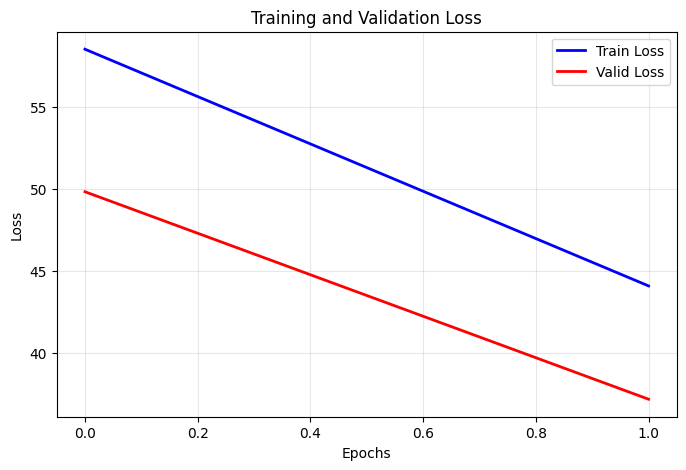

In [44]:
def plot_history(history_train, history_valid):
    plt.figure(figsize=(8, 5))
    plt.plot(history_train, 'b-', linewidth=2, label='Train Loss')
    plt.plot(history_valid, 'r-', linewidth=2, label='Valid Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_history(history['train_loss'], history['valid_loss'])

## 5. Test the model and plot reconstruction & residuals

In [ ]:
def anomaly_score(reconstruction, original):
    # Shape: (batch_size, channel, height, width)
    residuals = np.abs(reconstruction - original)
    anomaly_score = np.sum(residuals, axis=(1, 2, 3))
    return anomaly_score

In [ ]:
def find_testing_anomaly_threshold(validation_anomaly_scores, alpha=1.5):
    """
    Trouve le seuil d'anomalie pour les données de test en utilisant l'algorithme de Tukey.
    
    Args:
        anomaly_scores: Scores d'anomalie
        alpha: Coefficient multiplicateur pour le seuil d'anomalie
    
    Returns:
        threshold: Seuil d'anomalie
    """
    s_valid = np.max(validation_anomaly_scores)
    threshold = s_valid * alpha
    return threshold

In [ ]:
def test_and_detect_anomalies(model, test_loader, gap_time=10, test_start_point=10000, test_end_point=20000,
                              valid_start_point=8000, valid_end_point=10000, thred_broken=0.005, alpha=1.5):
    """
    Teste le modèle et détecte les anomalies
    
    Args:
        model: Modèle MSCRED entraîné
        test_loader: DataLoader pour les données de test
        gap_time: Intervalle de temps entre les matrices de signature
        test_start_point: Point de début du test en steps originaux
        test_end_point: Point de fin du test en steps originaux
        valid_start_point: Point de début de la validation en steps originaux
        valid_end_point: Point de fin de la validation en steps originaux
        thred_broken: Seuil pour les pixels cassés
        alpha: Coefficient multiplicateur pour le seuil d'anomalie
    
    Returns:
        reconstruction: Matrices reconstruites
        residuals: Matrices résiduelles
        anomaly_score: Scores d'anomalie
    """
    print("------Testing-------")
    model.to(device)
    model.eval()
    
    # Initialisation des arrays pour stocker les résultats
    reconstruction = []
    residuals = []
    anomaly_score = []
    
    # Conversion des points en indices de matrice
    valid_start = valid_start_point // gap_time
    valid_end = valid_end_point // gap_time
    test_start = test_start_point // gap_time
    test_end = test_end_point // gap_time
    
    with torch.no_grad():
        for i, x in enumerate(tqdm(test_loader)):
            x = x.to(device)
            
            # Reconstruction
            reconstructed_matrix = model(x)
            
            # Calcul des résidus
            residual = torch.abs(reconstructed_matrix - x)
            residuals.append(residual.cpu())
            
            # Stockage de la reconstruction
            reconstruction.append(reconstructed_matrix.cpu())
            
            # Calcul du score d'anomalie (nombre de pixels cassés)
            for j in range(x.size(0)):
                residual_matrix = residual[j]
                num_broken = torch.sum(residual_matrix > thred_broken).item()
                anomaly_score.append(num_broken)
    
    # Conversion en tensors
    reconstruction = torch.cat(reconstruction, dim=0)
    residuals = torch.cat(residuals, dim=0)
    anomaly_score = np.array(anomaly_score)
    
    return reconstruction, residuals, anomaly_score

# Fonction pour visualiser les scores d'anomalie
def plot_anomaly_scores(anomaly_score, test_start, test_end, valid_start, valid_end, 
                        gap_time, alpha, anomalies_info=None):
    """
    Trace les scores d'anomalie avec les zones d'anomalies ground truth
    """
    # Calcul du seuil basé sur la période de validation
    valid_scores = anomaly_score[valid_start:valid_end]
    valid_anomaly_max = np.max(valid_scores)
    threshold = valid_anomaly_max * alpha
    
    # Préparation du graphique
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Tracé des scores d'anomalie
    test_num = test_end - test_start
    x_values = np.arange(test_num)
    ax.plot(x_values, anomaly_score[test_start:test_end], color='black', linewidth=2, label='Anomaly Score')
    
    # Ligne de seuil
    ax.axhline(y=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold ({threshold:.2f})')
    
    # Ajout des zones d'anomalies ground truth si disponibles
    if anomalies_info:
        for info in anomalies_info:
            start_idx = (info['start_index'] - test_start * gap_time) // gap_time
            duration = info['duration'] // gap_time
            ax.axvspan(start_idx, start_idx + duration, color='red', alpha=0.3, label='Anomaly Ground Truth' if 'Anomaly Ground Truth' not in plt.gca().get_legend_handles_labels()[1] else "")
    
    ax.set_xlabel('Test Time (matrix index)')
    ax.set_ylabel('Anomaly Score')
    ax.set_title('Anomaly Detection Results')
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout()
    plt.savefig('./outputs/anomaly_score.png')
    plt.show()
    
    return threshold

# Fonction pour visualiser les matrices de signature
def plot_signature_matrices(original, reconstructed, residual, indices, titles):
    """
    Affiche les matrices originales, reconstruites et résiduelles pour des indices donnés
    """
    n_indices = len(indices)
    fig, axes = plt.subplots(n_indices, 3, figsize=(15, 5*n_indices))
    
    if n_indices == 1:
        axes = axes.reshape(1, -1)
    
    for i, idx in enumerate(indices):
        # Matrice originale
        axes[i, 0].imshow(original[idx].mean(dim=0), cmap='viridis')
        axes[i, 0].set_title(f'{titles[i]} - Original (Index {idx})')
        axes[i, 0].set_xlabel('Width')
        axes[i, 0].set_ylabel('Height')
        
        # Matrice reconstruite
        axes[i, 1].imshow(reconstructed[idx].mean(dim=0), cmap='viridis')
        axes[i, 1].set_title(f'{titles[i]} - Reconstructed (Index {idx})')
        axes[i, 1].set_xlabel('Width')
        axes[i, 1].set_ylabel('Height')
        
        # Matrice résiduelle
        res_mean = residual[idx].mean(dim=0)
        im = axes[i, 2].imshow(res_mean, cmap='hot')
        axes[i, 2].set_title(f'{titles[i]} - Residual (Index {idx})\nMean: {res_mean.mean():.4f}, Max: {res_mean.max():.4f}')
        axes[i, 2].set_xlabel('Width')
        axes[i, 2].set_ylabel('Height')
        plt.colorbar(im, ax=axes[i, 2])
    
    plt.tight_layout()
    plt.savefig('./outputs/signature_matrices_comparison.png')
    plt.show()

# Fonction pour analyser les performances de détection
def analyze_detection_performance(anomaly_score, threshold, anomalies_info, test_start, gap_time):
    """
    Analyse les performances de détection d'anomalies
    """
    # Détection des anomalies basée sur le seuil
    detected_anomalies = anomaly_score > threshold
    
    # Calcul des métriques si les ground truth sont disponibles
    if anomalies_info:
        tp, fp, fn = 0, 0, 0
        
        # Création d'un array pour les anomalies ground truth
        gt_anomalies = np.zeros_like(anomaly_score, dtype=bool)
        for info in anomalies_info:
            start_idx = (info['start_index'] - test_start * gap_time) // gap_time
            end_idx = start_idx + (info['duration'] // gap_time)
            gt_anomalies[start_idx:end_idx] = True
        
        # Calcul des vrais positifs, faux positifs et faux négatifs
        tp = np.sum(detected_anomalies & gt_anomalies)
        fp = np.sum(detected_anomalies & ~gt_anomalies)
        fn = np.sum(~detected_anomalies & gt_anomalies)
        
        # Calcul de la précision et du rappel
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"True Positives: {tp}")
        print(f"False Positives: {fp}")
        print(f"False Negatives: {fn}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1_score:.4f}")
    
    return detected_anomalies

In [45]:
def test(model, dataLoader):
    print("------Testing-------")
    reconstructed_data_path = "../data/matrix_data/reconstructed_data/"
    os.makedirs(reconstructed_data_path, exist_ok=True)
    for element in dataLoader:
        element_shape = element.shape
        break
    reconstruction = torch.zeros((len(dataLoader)*element_shape[0], *element_shape[1:]))
    loss = 0
    i = 0

    model.to(device)
    model.eval()
    with torch.no_grad():
        for x in tqdm(dataLoader):
            x = x.to(device)
            x = x.squeeze()
            reconstructed_matrix = model(x) 
            
            l = loss_function(reconstructed_matrix, x)
            loss += l.item()
            #print("[test_index %d] [loss: %f]" % (i, l.item()))

            reconstruction[i*element_shape[0]:(i+1)*element_shape[0]] = reconstructed_matrix.cpu().detach()
            i += 1
        loss /= len(dataLoader)
        print("Final loss: [loss: %f]" % (loss))

        path_temp = os.path.join(reconstructed_data_path, "reconstructed_data.npy")
        np.save(path_temp, reconstruction.cpu().detach().numpy())
    return reconstruction

In [46]:
# Validation
mscred.load_state_dict(torch.load("./checkpoints/model1.pth"))
mscred.to(device)
reconstruction = test(mscred, test_loader)


------Testing-------


100%|██████████| 125/125 [00:08<00:00, 15.15it/s]


Final loss: [loss: 37.117008]


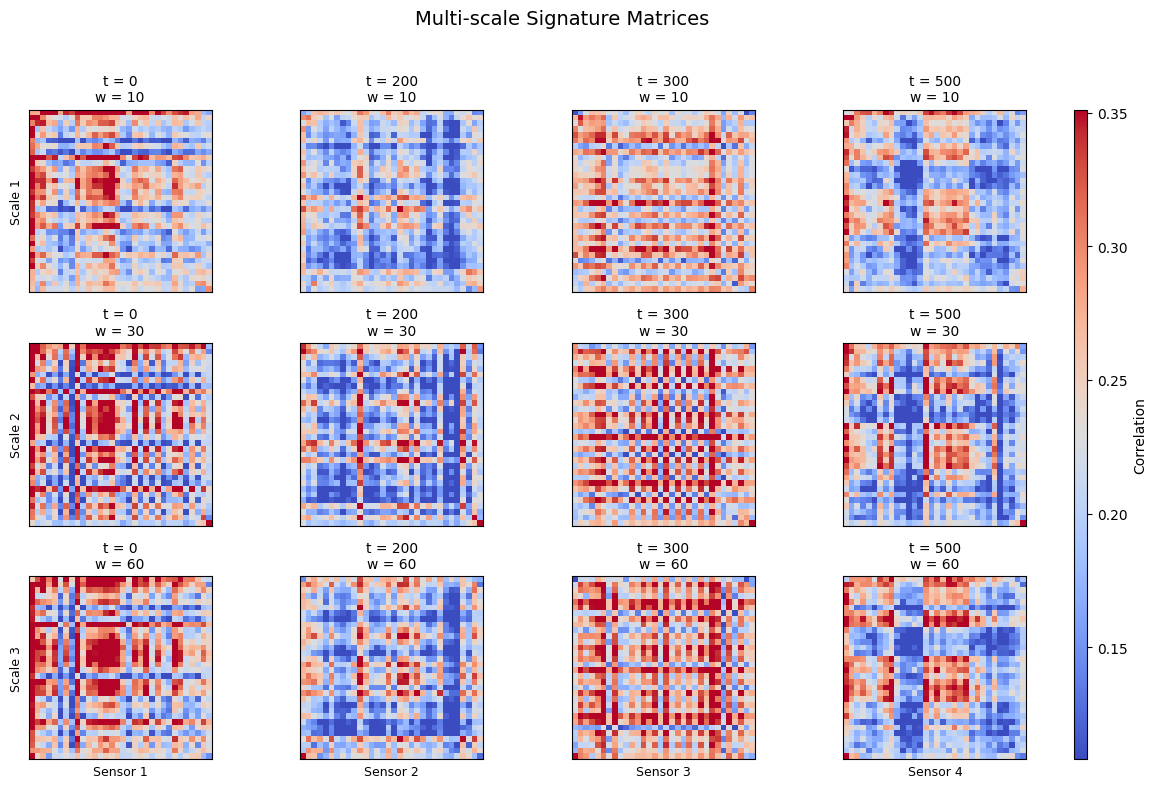

In [47]:
plot_signature_matrices(
    matrix_4d=reconstruction,
    sample_times=[0, 200, 300, 500]
)

In [48]:
# Calculate the residual matrix between reconstruction matrices and signature matrices
residuals = torch.abs(reconstruction - signature_matrices[15000//gap_time:20000//gap_time])

In [49]:
# Calculate the score of anomaly (scalar)
anomaly_score = torch.sum(residuals, dim=(1, 2, 3)).cpu().detach().numpy()

In [50]:
# Sort by ascending anomaly score
sorted_indices = np.argsort(anomaly_score)
sorted_indices

array([117, 118, 116, 452, 382, 383, 222, 453, 115, 201, 119, 375, 451,
       223,  46,  45, 377, 376, 200,  44, 419, 221, 295, 275, 202,  47,
       381, 418,  16, 224, 321, 378, 306, 420, 253, 141, 274,  43, 320,
        99, 406, 319, 252, 307, 163, 343, 454, 265, 225, 408, 395, 331,
       379, 220, 407, 162, 158, 344, 142, 254,  65, 294, 394, 450, 330,
       164, 384, 380,  63, 114, 405, 143,  42, 464, 455,  15, 404, 199,
       463, 308, 309,  48,  64, 322, 264, 373, 157, 305, 152, 345, 203,
       266, 374, 251, 273, 332, 477, 255, 100, 396, 227, 296,  17, 346,
       426, 494, 140,  22, 276, 462,  14, 120, 495, 465, 493, 417, 226,
       218, 342,  98, 219, 173, 216, 166, 353, 354, 179, 180, 363, 160,
       156,  56, 299, 256, 161,  74, 449,  94,  96,  54, 190, 293,  53,
       165, 267, 397, 359, 409, 478, 217, 153, 234, 159, 492, 277, 228,
       358, 456, 155, 427, 347,  41,   6, 310, 437, 365, 145, 438, 233,
       439, 297, 364,  55, 144, 441, 303, 204, 287, 232, 215, 40

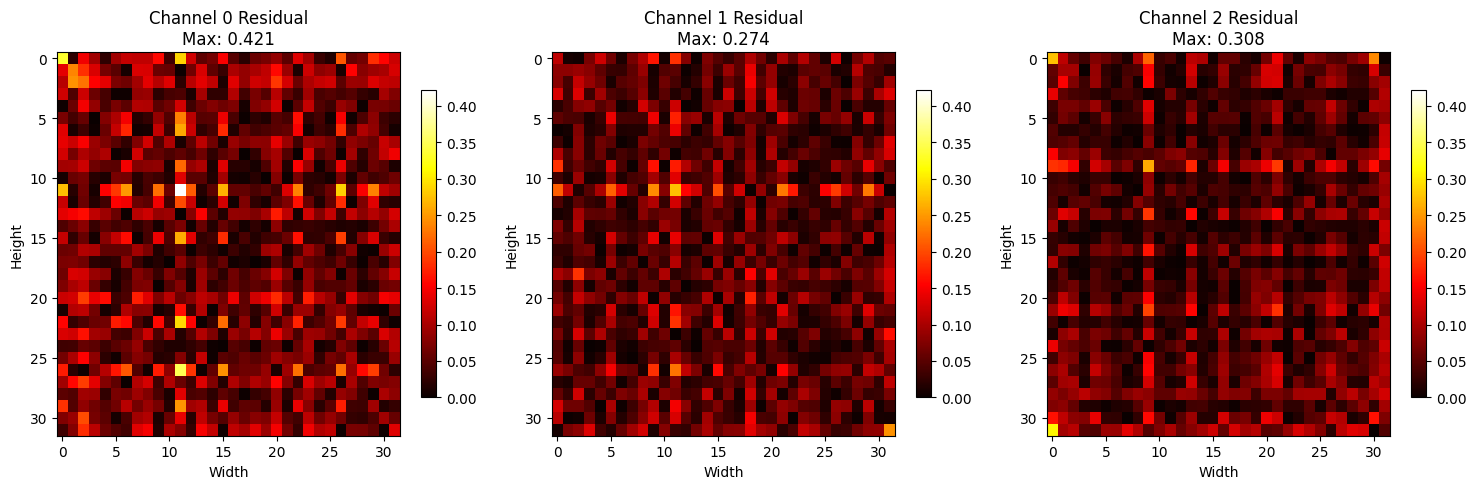

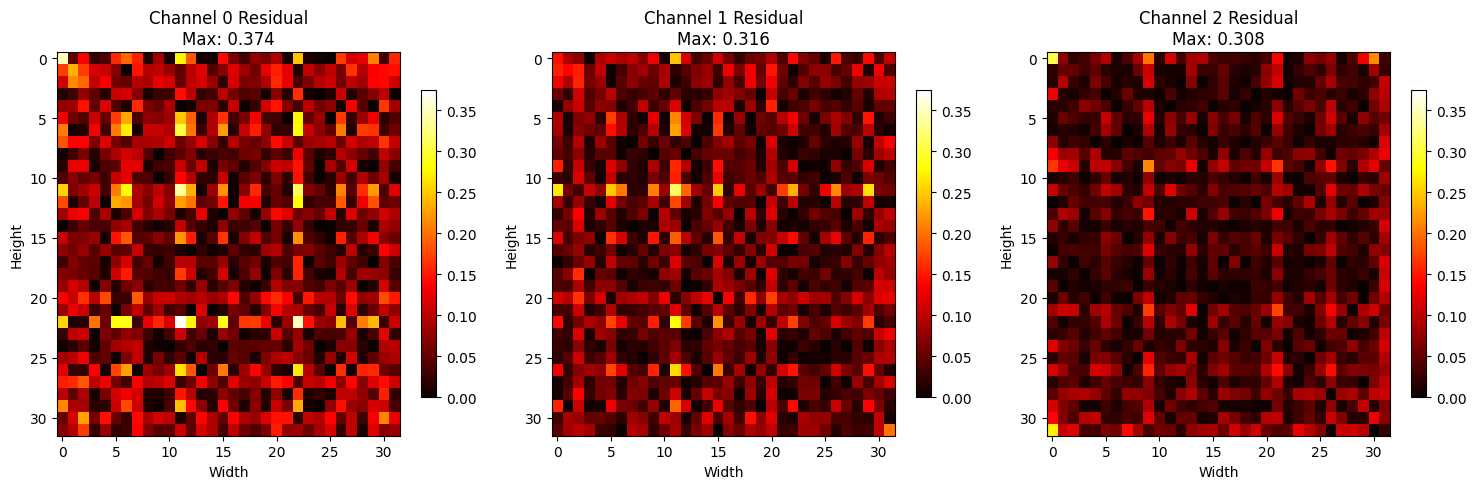

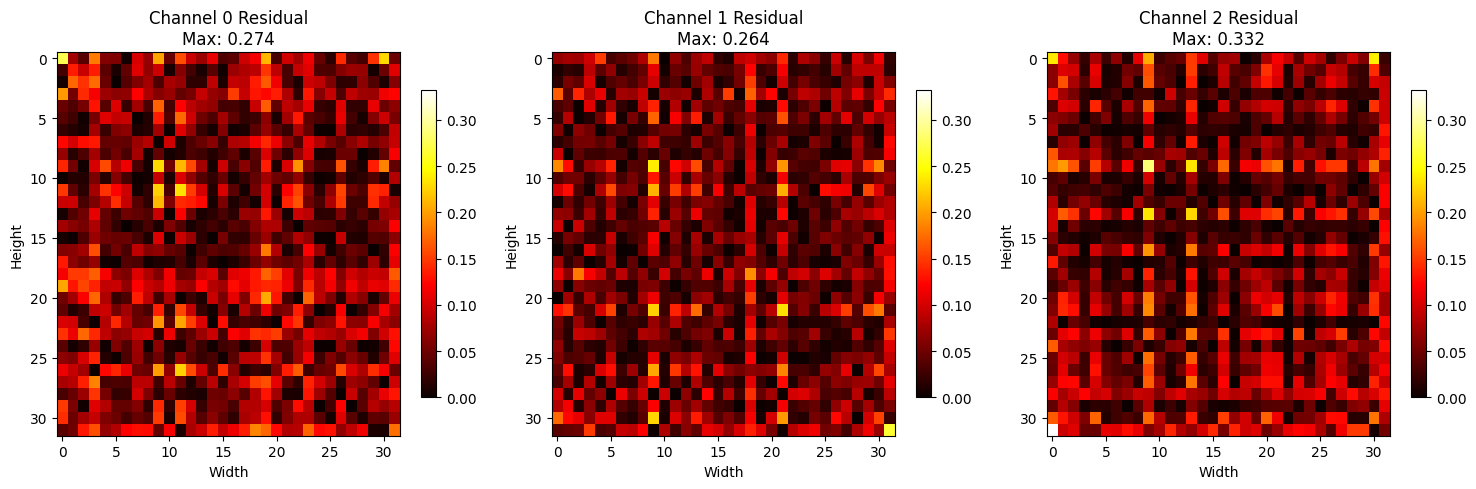

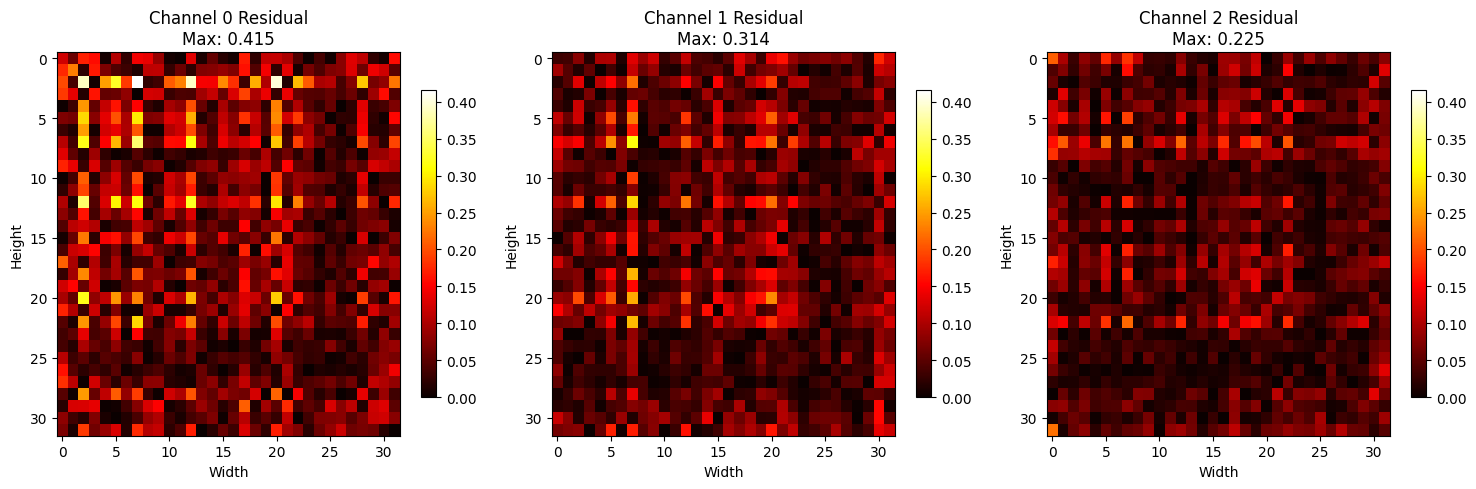

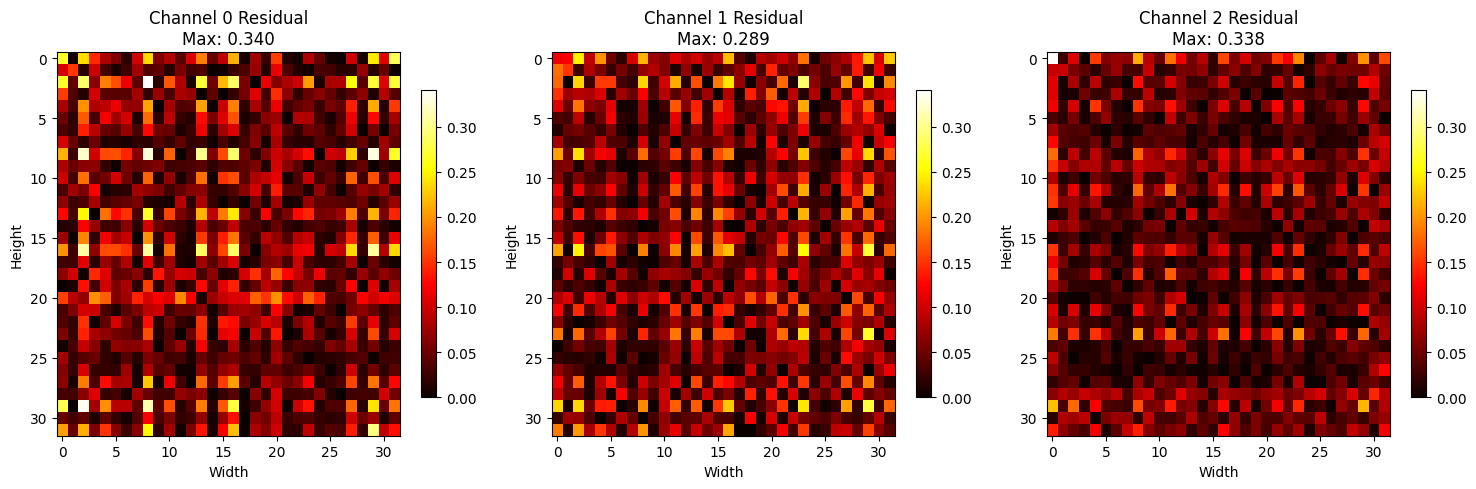

In [51]:
# Plot the 5 most anomalous samples
# Plot the 3 residual channels for the 5 worst reconstructions
for i in range(5):
    index = sorted_indices[i]
    
    # Create figure with 1 row and 3 columns for the 3 residual channels
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Get residual matrix for this sample (shape: [3, 32, 32])
    residual_matrix = residuals[index].cpu().detach().numpy()
    
    # Plot each residual channel separately
    for channel in range(3):
        im = axes[channel].imshow(residual_matrix[channel], 
                                 aspect='auto', 
                                 cmap='hot',  # Colormap appropriée pour les résidus
                                 vmin=0,      # Les résidus sont toujours positifs
                                 vmax=residual_matrix.max())  # Même échelle pour tous les canaux
        
        axes[channel].set_title(f'Channel {channel} Residual\nMax: {residual_matrix[channel].max():.3f}')
        axes[channel].set_xlabel('Width')
        axes[channel].set_ylabel('Height')
        
        # Add colorbar
        plt.colorbar(im, ax=axes[channel], shrink=0.8)
    
    plt.tight_layout()
    plt.show()